## Ames5 Final Model and Submissions 
* Prepare training and test data
* Transforamtions
* Encoding
* Cross valiadations
* model training
* hyperparameter tuning : 
* model saving with pickle
* Submissions

In [ ]:
#PCA
X["Feature1"] = X.GrLivArea + X.TotalBsmtSF
X["Feature2"] = X.YearRemodAdd * X.TotalBsmtSF

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

import time

In [4]:
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)

In [94]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
#from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV,LinearRegression,Lasso, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor,RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import IsolationForest
#from mlxtend.regressor import StackingCVRegressor # This is for stacking part, works well with sklearn and others...

In [18]:
def advance_outlier_removal(df,isolation_forest=True,elliptic_envelope=True,local_of = True):
    df = df.copy()
    print(f'No inf values in df: {np.all(np.isfinite(df))}')
    #print(f'No inf values in test_df:{np.all(np.isfinite(test_df))}')
    def clean_dataset(df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
        bad_indices = df.isin([np.nan, np.inf, -np.inf]).any(1)
        display(df[bad_indices])
        return df[indices_to_keep].astype(np.float64)
    df_num = clean_dataset(df)
    #print(df.shape,df_num.shape)
    df_num = df_num.select_dtypes(exclude='O')
    
    #display(df_num)
    
    if isolation_forest is True:
        iso = IsolationForest().fit(df_num)
        iso_preds = iso.predict(df_num)
        iso_scores = abs(iso.score_samples(df_num))
        df.loc[:,'iso_out_preds'] = iso_preds
        mask = (df.iso_out_preds==1)
        df['iso_out_preds'] = np.where(mask,0,-1)
        #df.loc[:,'iso_out_scores'] = iso_scores
        #print(df.shape,df_num.shape)
    return df

In [17]:
advance_outlier_removal(df=train.select_dtypes(exclude='O'),isolation_forest=True,elliptic_envelope=True,local_of = True)

No inf values in df: False


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


(1121, 38) (1121, 38)
(1121, 39) (1121, 38)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,iso_out_preds
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,-1
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0


In [11]:
    def clean_dataset(df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
        bad_indices = df.isin([np.nan, np.inf, -np.inf]).any(1)
        display(df[bad_indices])
        return df[indices_to_keep].astype(np.float64)

In [13]:
def get_outlier(df,columns,target='SalePrice'):
    df= df.copy()
    df = base_df= clean_dataset(df[columns+[target]])
    formated=[]
    for feature in columns:
            #print(feature)
            gr_sp = advance_outlier_removal(df=df[[target, feature]],isolation_forest=True,elliptic_envelope=True,local_of = True)
            new_cols = [i +'_' +feature for i in ['iso_out_preds']]
            #print(new_cols)
            old_new_dict = dict(zip(['iso_out_preds'],new_cols))
            #display(old_new_dict)
            gr_sp.rename(columns = old_new_dict,inplace=True)
            #display(gr_sp.head())
            formated.append(gr_sp.loc[:,new_cols])
    outlier = pd.concat(formated,axis=1)
    df = pd.concat([base_df,outlier],axis=1)
    #display(df.isna().sum()[df.isna().sum()>0])
    df = df.dropna()
    return df
get_outlier(df=train.select_dtypes(exclude='O'),columns=['GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea'],target='SalePrice')

<ipython-input-11-367d0a38fc6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice


No inf values in df: True


,SalePrice,GrLivArea


No inf values in df: True


,SalePrice,1stFlrSF


No inf values in df: True


,SalePrice,TotalBsmtSF


No inf values in df: True


,SalePrice,GarageArea


,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea
0,1710.0,856.0,856.0,548.0,208500.0,0,0,0,0
1,1262.0,1262.0,1262.0,460.0,181500.0,0,0,0,0
2,1786.0,920.0,920.0,608.0,223500.0,0,0,0,0
3,1717.0,961.0,756.0,642.0,140000.0,0,0,0,0
4,2198.0,1145.0,1145.0,836.0,250000.0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...
1455,1647.0,953.0,953.0,460.0,175000.0,0,0,0,0
1456,2073.0,2073.0,1542.0,500.0,210000.0,0,-1,0,0
1457,2340.0,1188.0,1152.0,252.0,266500.0,0,0,0,-1
1458,1078.0,1078.0,1078.0,240.0,142125.0,0,0,0,0


In [340]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head().T

(1460, 81)


,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [22]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head().T

(1459, 80)


,0,1,2,3,4
Id,1461,1462,1463,1464,1465
MSSubClass,20,20,60,60,120
MSZoning,RH,RL,RL,RL,RL
LotFrontage,80.0,81.0,74.0,78.0,43.0
LotArea,11622,14267,13830,9978,5005
...,...,...,...,...,...
MiscVal,0,12500,0,0,0
MoSold,6,6,3,6,1
YrSold,2010,2010,2010,2010,2010
SaleType,WD,WD,WD,WD,WD


In [23]:
#test.loc['YearBuilt','YearRemodAdd','YrSold']
test[test.YearBuilt > test.YrSold]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1089,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial


In [24]:
for col in ['YearBuilt','YearRemodAdd','YrSold']:
    test.loc[1089,col]=np.nan
test.loc[1089,['YearBuilt','YearRemodAdd','YrSold']]

YearBuilt       NaN
YearRemodAdd    NaN
YrSold          NaN
Name: 1089, dtype: object

In [25]:
test[test.YearBuilt > test.YearRemodAdd]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
416,1877,20,RL,65.0,10739,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2002.0,2001.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,Gd,TA,PConc,Gd,TA,No,GLQ,1259.0,Unf,0.0,172.0,1431.0,GasA,Ex,Y,SBrkr,1444,0,0,1444,1.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,144,40,0,0,0,0,NaN,NaN,NaN,0,4,2009.0,WD,Normal


In [26]:
for col in ['YearBuilt','YearRemodAdd','YrSold']:
    test.loc[416,col]=np.nan
test.loc[416,['YearBuilt','YearRemodAdd','YrSold']]

YearBuilt       NaN
YearRemodAdd    NaN
YrSold          NaN
Name: 416, dtype: object

In [27]:
test.loc[:,'SalePrice']='test_col'

In [347]:
def prepare_X_con(df,is_train=False):
    df_def = df.copy()
    if is_train == True:
        #GrLivArea 4000,1stFlrSF 2500 ,TotalBsmtSF 3000 ,GarageArea 1200
        condition = (df.GrLivArea <4000) & (df['1stFlrSF'] < 2500) & (df.TotalBsmtSF < 3000) & ( df.GarageArea  < 1200) & (df.MasVnrArea<1000)
        df_def = df[condition]
        
    target_values = df_def.pop('SalePrice')
    
    df_def.loc[:,'MSSubClass'] = df_def['MSSubClass'].astype(str)
    
    
    created_features= []
    drops=[]
    
    def knn_impute(df, na_target):
        df = df.copy()

        numeric_df = df.select_dtypes(np.number)#.drop('SalePrice',axis=1)
        #display(numeric_df)
        non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

        y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
        X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
        X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]

        knn = KNeighborsRegressor()
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        plt.show()
        df.loc[df[na_target].isna() == True, na_target] = y_pred

        return df
    #fill na
    train_num_null = df_def[df_def.select_dtypes(np.number).columns].isna().sum()
    num_col_with_na = train_num_null[train_num_null>0].index.tolist()
    print("Numeric Columns with NA",num_col_with_na)
    for column in num_col_with_na:
        df_def = knn_impute(df_def, column)
    print("NA handled successfully")
    print()
    
    #feature engineering
    def adding_similar_features(new_col,features):
        new_feature = 'total_'+new_col
        df_def[new_feature] = df_def[features].sum(axis=1)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    def Count_Feat_Engr(components,new_feature):
        df_def[new_feature] = df_def[components].gt(0).sum(axis=1)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    def Ratio(a,b,ratio_name):
        new_feature = ratio_name
        df_def[new_feature] = df_def[a]/df_def[b]
        mask = df_def[b]==0
        df_def.loc[mask,new_feature]=0 # to handle infinity
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    def Similar_Category2d(column,feature_name,similar_categories_2d_array,category_array):
        new_feature = feature_name
        df_def[new_feature] = df_def[column]
        for idx,similar_categories1d in enumerate(similar_categories_2d_array):
                #for element in arr1d:
                #column=element
                rows_with_matches = df_def[column].isin(similar_categories1d)
                df_def.loc[rows_with_matches,new_feature] = category_array[idx]
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        
    def make_clusters_category(df,target,features_list,cluster_name_list, n_clusters=10,as_category= False):
        X = df.copy()
        #y = X.pop(target)
        new_cols=[]
        #features = ['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF','GrLivArea']
        for features,cluster_name in zip(features_list,cluster_name_list):
            # Standardize
            X_scaled = X.loc[:, features]
            X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

            # Fit the KMeans model to X_scaled and create the cluster labels
            kmeans = KMeans( n_clusters=n_clusters, random_state=0)

            X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
            new_feature  = cluster_name + "_Cluster" 
            X[new_feature] = kmeans.fit_predict(X_scaled)
            
            if as_category == True:
                X[new_feature]=  X[new_feature].astype('category')
            new_cols.append(new_feature)
        created_features.extend(new_cols)
        print(f"Created New_Feat : '{new_cols}' succesfully!")
        print("Created Features list :",created_features)
        print()    
        #X[target]=y
        return X

    def fundamentals():
        #'YearBuilt', 'YearRemodAdd','GarageYrBlt'
        df_def['Age_YrBuilt'] = df_def.YrSold - df_def.YearBuilt
        df_def['Age_YrRmd'] = df_def.YrSold - df_def.YearRemodAdd
        df_def['Diff_YrRmd_YrBlt'] = df_def.YearRemodAdd - df_def.YearBuilt
        df_def['Age_GarageYrBlt'] = df_def.YrSold - df_def.GarageYrBlt
        df_def['Diff_GarYBlt_YrBlt'] = df_def.GarageYrBlt - df_def.YearBuilt
        
        df_def["LivLotRatio"] = df_def.GrLivArea  /df_def.LotArea
        df_def["Spaciousness"] = (df_def['1stFlrSF'] + df_def['2ndFlrSF']) / df_def.TotRmsAbvGrd
        df_def["GrArea+Basement"] = df_def.GrLivArea + df_def.TotalBsmtSF
        df_def["YrRemod*Basement"] = df_def.YearRemodAdd * df_def.TotalBsmtSF
        #df_def["TotalOutsideSF"] =  df_def.WoodDeckSF + df_def.OpenPorchSF + df_def.EnclosedPorch + df_def.Threeseasonporch + df_def.ScreenPorch
        #df_def["PorchTypes"] = df_def[['WoodDeckSF','OpenPorchSF','EnclosedPorch','Threeseasonporch','ScreenPorch']].gt(0).sum(axis=1)
        new_cols = ['Age_YrBuilt','Age_YrRmd','Diff_YrRmd_YrBlt','Age_GarageYrBlt','Diff_GarYBlt_YrBlt',"LivLotRatio","Spaciousness","GrArea+Basement","YrRemod*Basement"]
        created_features.extend(new_cols)
        print(f"Created New_Feat : '{new_cols}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    def from_kaggle1():
        #Gabriel Atkin
        df_def["SqFtPerRoom"] = df_def["GrLivArea"] / (df_def["TotRmsAbvGrd"] +
                                                       df_def["FullBath"] +
                                                       df_def["HalfBath"] +
                                                       df_def["KitchenAbvGr"])

        df_def['Total_Home_Quality'] = df_def['OverallQual'] + df_def['OverallCond']
        df_def['Product_Home_Quality'] = df_def['OverallQual'] * df_def['OverallCond']

        df_def['Total_Bathrooms'] = (df_def['FullBath'] + (0.5 * df_def['HalfBath']) +
                              df_def['BsmtFullBath'] + (0.5 * df_def['BsmtHalfBath']))
        
        new_cols= ["SqFtPerRoom",'Total_Home_Quality','Product_Home_Quality','Total_Bathrooms']
        created_features.extend(new_cols)
        print(f"Created New_Feat : '{new_cols}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    def from_kaggle2(features):        
        #BarbosaFelipeB
         #The Quality features
        
        features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                               features['1stFlrSF'] + features['2ndFlrSF'])
        
        features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                    features['EnclosedPorch'] +
                                    features['ScreenPorch'] + features['WoodDeckSF'])

        features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

        # Merging quality and conditions.

        features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
        features['ProductExtQual'] = (features['ExterQual'] * features['ExterCond'])
        
        features['TotalBsmQual_And_Fin'] = (features['BsmtQual'] + features['BsmtCond'] +features['BsmtFinType1'] +features['BsmtFinType2'])
        features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'])
        features['ProductBsmQual'] = (features['BsmtQual'] * features['BsmtCond'])
        features['TotalBsmFin'] = (features['BsmtFinType1'] + features['BsmtFinType2'])
        #Ratio(a,b,ratio_name)
        
        features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
        features['ProductGrgQual'] = (features['GarageQual'] * features['GarageCond'])
        
        features['TotalQual'] = features['OverallQual'] + features[
            'TotalExtQual'] + features['TotalBsmQual_And_Fin'] + features[
                'TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

        # Creating new features by using new quality indicators.

        features['QualGr'] = features['TotalQual'] * features['GrLivArea']
        features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
        features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
        features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
        features['QlLivArea'] = (features['GrLivArea'] -
                                 features['LowQualFinSF']) * (features['TotalQual'])
        features['QualSFNg'] = features['QualGr'] * features['Neighborhood_mapped']
        #data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]
        new_cols= ['TotalSF','TotalPorchSF','YearBlRm','TotalExtQual','ProductExtQual','TotalBsmQual_And_Fin',
                  'TotalBsmQual','TotalBsmFin','TotalGrgQual','ProductGrgQual','TotalQual','QualGr','QualPorch'
                  'QualExt','QualGrg','QlLivArea']
        created_features.extend(new_cols)
        print(f"Created New_Feat : '{new_cols}' succesfully!")
        print("Created Features list :",created_features)
        print()
        
    from_kaggle1()
    from_kaggle2(features=df_def)
    Ratio(a='ProductBsmQual',b='TotalBsmFin',ratio_name='ProBsmQualPerTotFin')
    fundamentals()
    #"TotalOutsideSF"
    OutsideSF = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    #adding_similar_features(new_col='OutsideSF',features=OutsideSF)
    Count_Feat_Engr(components=OutsideSF,new_feature='Count_OutSideSF')
    Ratio(a='TotalPorchSF',b='Count_OutSideSF',ratio_name='Rat_Out_Count')
    
    #Area
    Areas=['LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', 'PoolArea','TotalBsmtSF']
    adding_similar_features(new_col='Area',features=Areas)
    Count_Feat_Engr(components=Areas,new_feature='Count_Areas')
    Ratio(a='total_Area',b='Count_Areas',ratio_name='Rat_Areas_Count')
    
    #Floors squarefeet
    Floors = ['1stFlrSF', '2ndFlrSF']
    adding_similar_features(new_col='Floors',features=Floors)
    Count_Feat_Engr(components=Floors,new_feature='Count_Floors')
    Ratio(a='total_Floors',b='Count_Floors',ratio_name='Rat_Floors_Count')
    
    #BaseMent Finish
    Bsmt_FinSF = ['BsmtFinSF1', 'BsmtFinSF2']
    #adding_similar_features(new_col='Bsmt_FinSF',features=Bsmt_FinSF)
    Ratio(a='TotalBsmtSF',b='TotalBsmFin',ratio_name='Tot_Bsmt_per_Fin')
    
    #NumCat
    #FirePlace#OverallCond
    Similar_Category2d(column='OverallCond',feature_name='OverallCond_Price_grade',similar_categories_2d_array=
                       [[5],[9,6,7,8],[4,3,2,1]],category_array=[2,3,1])
    
    #cluster
    space= ['LotArea', 'GrLivArea','1stFlrSF', '2ndFlrSF','TotalBsmtSF']
    YrBlt = ['YearBuilt']
    OverAll_QC = ['OverallQual','OverallCond','ProductBsmQual',]
    
    cluster_features=[space,Areas,Floors,OutsideSF,OverAll_QC]
    cluster_alias=['space','Areas','Floors','OutsideSF','OverAll_QC']
    
    df_def=  make_clusters_category(df=df_def,target='SalePrice',features_list=cluster_features,cluster_name_list=cluster_alias)
    df_def=  make_clusters_category(df=df_def,target='SalePrice',features_list=[YrBlt],cluster_name_list=['YrBlt'],n_clusters=3)
    skew_df = df_def.copy()
    display(skew_df.head(2))
    #feature transformation
    def normalise_skew_with_log(df):
        df_def = df.copy()
        skew_df = pd.DataFrame(df.select_dtypes(np.number).columns, columns=['Feature'])
        skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature].dropna()))
        skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
        skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
        display(skew_df.head(2))
        print('skewed columns:')
        display(skew_df.query("Skewed == True")['Feature'].values)
        print()
        for column in skew_df.query("Skewed == True")['Feature'].values:
            df[column] = np.log1p(df[column])
            
        num_null = df[df.select_dtypes(np.number).columns].isna().sum()
        num_col_with_na = num_null[num_null>0].index.tolist()
        
        if len(num_col_with_na)> 0:
            for column in num_col_with_na:
                df[column] = df_def[column]
                
        print("skewed features handled")
        print()
    normalise_skew_with_log(df_def)
    
    #Month is a cyclic feature
    ##Gabriel Atkin
    df_def.loc[:,'Cyclic_MoSold'] = (-np.cos(0.5236 * df_def['MoSold']))
    created_features.append('Cyclic_MoSold')
    print('monthsold transformed to a cyclic feature')
    print()
    drops.extend(['PoolQC',    'YrSold',    'MoSold',    'ExterQual','BsmtQual','GarageQual',    'KitchenQual',    'HeatingQC',])
    print('dropping')
    display(drops)
    df_def=df_def.drop(drops,axis=1)
    skew_df = skew_df.drop(drops,axis=1)
    #df_def = pd.get_dummies(data=df_def)
    df_def['SalePrice']=target_values
    if is_train == True:
        outlier_cols =['GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea']
        df_with_outlier = get_outlier(df=df_def.select_dtypes(exclude='O'),columns=['GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea'],target='SalePrice')
        df_def_main = df_def.drop(outlier_cols +['SalePrice'],axis=1)

        df_def = pd.concat([df_def_main,df_with_outlier],axis=1)

    return df_def,skew_df#,created_features

In [31]:
prepare_X_con(df=data)

Numeric Columns with NA ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']

Created New_Feat : 'ProBsmQualPerTotFin' succesfully!
Created Features list : ['SqFtPe

2    821
3    551
1     88
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'GrArea+Basement', 'YrRemod*Basement', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list 

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.914130,1.914130,True
1,LotArea,12.195142,12.195142,True


skewed columns:


array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'Neighborhood_mapped', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'TotalSF', 'TotalPorchSF', 'ProductExtQual',
       'TotalBsmQual_And_Fin', 'TotalBsmQual', 'ProductBsmQual',
       'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr',
       'Q


skewed features handled

monthsold transformed to a cyclic feature

dropping


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

<ipython-input-11-367d0a38fc6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice


No inf values in df: True


,SalePrice,GrLivArea


No inf values in df: True


,SalePrice,1stFlrSF


No inf values in df: True


,SalePrice,TotalBsmtSF


No inf values in df: True


,SalePrice,GarageArea


,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea
0,60,RL,4.189655,9.042040,CollgCr,1Fam,2Story,7,1.791759,7.602900,7.602900,BrkFace,5.283204,1.386294,1.386294,No,6,6.561031,0.693147,0.000000,5.017280,6.751101,0.0,0.693147,0.000000,2,0.693147,3,0.693147,2.197225,0.000000,0,Attchd,7.602900,RFn,2,1.386294,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,0,2.197225,4.966335,12,35,3.5,7.790282,4.127134,4006,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.205462,6.059123,7.224753,3288,11.205462,CollgCrCollgCrCollgCrCollgCrCollgCrCollgCrColl...,0.998529,1.791759,1.791759,0.000000,1.791759,0.0,0.184292,5.369475,7.850493,14.354672,1,4.127134,9.372544,5,7.763446,7.444833,2,6.752270,4.814505,2,0,4,4,3,0.000000,0,-0.499998,7.444833,6.753438,6.753438,548.0,208500.0,0,0,0,0
1,20,RL,4.394449,9.169623,Veenker,1Fam,1Story,6,2.197225,7.589336,7.589336,None,0.000000,1.386294,1.386294,Gd,5,6.886532,0.693147,0.000000,5.652489,0.000000,0.0,0.000000,0.693147,2,0.000000,3,0.693147,1.945910,0.693147,3,Attchd,7.589336,RFn,2,1.386294,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.079442,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,0,1,1.945910,4.950335,14,48,2.5,7.714677,5.700444,3952,6,2.302585,2.639057,2.079442,2.564949,6,1.94591,2.302585,3.688879,10.804035,7.489412,0.000000,2760,10.804035,VeenkerVeenkerVeenkerVeenkerVeenkerVeenkerVeen...,1.098612,3.465736,3.465736,0.000000,3.465736,0.0,0.123507,5.353437,7.833996,14.729283,1,5.700444,9.440261,4,8.054205,7.141245,1,7.141245,5.353437,3,1,8,7,7,2.197225,1,0.866028,7.141245,7.141245,7.141245,460.0,181500.0,0,0,0,0
2,60,RL,4.234107,9.328212,CollgCr,1Fam,2Story,7,1.791759,7.601902,7.602401,BrkFace,5.093750,1.386294,1.386294,Mn,6,6.188264,0.693147,0.000000,6.075346,6.765039,0.0,0.693147,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,7.601902,RFn,2,1.386294,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,1,2.197225,5.190732,12,35,3.5,7.728856,3.761200,4003,7,2.564949,2.7

In [117]:
prepare_X_con(df=data_test)

Numeric Columns with NA ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualE

2    824
3    555
1     80
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality',

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.573196,0.573196,True
1,LotArea,3.112013,3.112013,True


skewed columns:


array(['LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'Total_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF',
       'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual',
       'ProductBsmQual', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual',
       'QualGr', 'QualPorch', 'QualExt


skewed features handled

monthsold transformed to a cyclic feature



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,concat_Exterior,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,SalePrice
0,20,RH,4.394449,9.360741,1.386294,1Fam,1Story,5,6,7.581720,1961,None,0.000000,1.386294,1.386294,No,3,6.150603,1.098612,4.976734,5.602119,6.783325,6.799056,0.000000,0.0,6.799056,0.000000,0.000000,1,0.000000,2,0.693147,1.791759,0.000000,0,Attchd,1961.0,Unf,1.0,730.0,1.386294,Y,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,VinylSd,VinylSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,VinylSd_VinylSd,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,0,2.079442,4.859812,2.484907,30,0.693147,7.319202,5.564520,3922,6,2.302585,2.484907,1.945910,2.302585,5,1.94591,2.302585,3.555348,10.324334,7.353082,0.000000,4380.0,10.324334,11.422924,1.029619,3.912023,49,0.000000,49.0,0.0,0.074268,5.194067,2,4.875197,9.556126,4,8.170044,6.799056,1,6.799056,5.178407,3,2,6,7,1,0,0,1.000000,test_col
1,20,RL,4.406719,9.565775,1.386294,1Fam,1Story,6,6,7.580189,1958,BrkFace,4.691348,1.386294,1.386294,No,5,6.828712,0.693147,0.000000,6.008813,7.192934,7.192934,0.000000,0.0,7.192934,0.000000,0.000000,1,0.693147,3,0.693147,1.945910,0.000000,0,Attchd,1958.0,Unf,1.0,312.0,1.386294,Y,5.976351,3.610918,0.0,0.0,0.000000,0.0,9.433564,Wd Sdng,Wd Sdng,None,Norm,WD,Hip,IR1,Lvl,Gtl,CBlock,Wd Sdng_Wd Sdng,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.0,0.693147,0.0,0,0,2.197225,5.001707,2.564949,36,0.916291,7.720018,6.063785,3916,6,2.302585,2.564949,1.945910,2.302585,6,1.94591,2.302585,3.637586,10.803120,7.853605,6.475433,1872.0,10.803120,11.901719,0.916291,3.970292,52,0.000000,52.0,0.0,0.089065,5.404927,2,5.372961,9.761117,5,8.151910,7.192934,1,7.192934,5.404927,3,4,2,1,4,0,0,1.000000,test_col
2,60,RL,4.317488,9.534668,1.791759,1Fam,2Story,5,5,7.599902,1998,None,0.000000,1.386294,1.386294,No,6,6.674561,0.693147,0.000000,4.927254,6.834109,6.834109,6.553933,0.0,7.396335,0.000000,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,1997.0,Fin,2.0,482.0,1.386294,Y,5.361292,3.555348,0.0,0.0,0.000000,0.0,0.000000,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,VinylSd_VinylSd,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,1,1,2.197225,5.099256,2.397895,25,1.252763,7.791936,5.509388,3995,6,2.302585,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.663562,11.033324,7.297768,0.000000,2892.0,11.033324,12.642749,0.998529,2.639057,12,0.693147,13.0,0.0,0.111351,5.607639,2,4.820282,9.733292,4,8.347176,7.396335,2,6.703801,4.894636,2,7,9,3,0,9,1,0.000004,

In [29]:
def prepare_X_cat(df):
    df_def = df.copy()
    target_values = df_def.pop('SalePrice')
    created_features= []
    drops=[]
    
    def Handling_Rare_Values(column,threshold):     
        #df_def[column] = df_def[column].fillna("NONE")
        condition_index = df_def[column].value_counts()[df_def[column]].values < threshold
        new_feature = 'rare_'+ column
        df_def[new_feature] = df_def[column]
        df_def.loc[condition_index, new_feature] = "RARE"
        created_features.append(new_feature)
        drops.append(column)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
    def adding_similar_features_Categorical(new_col,features):
        new_feature = 'concat_'+new_col
        combi = df_def[features].values
        df_def[new_feature] = [ '_'.join(feat) for feat in combi]
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
    def groupIn(column,group,feature_name,drop=False):
        new_feature = feature_name
        df_def[feature_name] =np.zeros(shape=df_def.shape[0], dtype=int)
        for category in group:
            mask = df_def[column]==category
            df_def.loc[mask,feature_name] = 1
        created_features.append(new_feature)
        if drop == True:
            drops.append(column)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        
    def adding_similar_features(new_col,features):
        new_feature='total_'+new_col    
        df_def[new_feature] = df_def[features].sum(axis=1)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
    
    def HandleNa():
        for column in [
            'Alley',
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinType2',
            'FireplaceQu',
            'GarageType',
            'GarageFinish',
            'GarageQual',
            'GarageCond',
            'PoolQC',
            'Fence',
            'MiscFeature'
            ]:
            df_def[column] = df_def[column].fillna("None")
            
            # Impute using the column mode
        for column in [
            'MSZoning',
            'Utilities',
            'Exterior1st',
            'Exterior2nd',
            'MasVnrType',
            'Electrical',
            'KitchenQual',
            'Functional',
            'SaleType'
            ]:
            df_def[column] = df_def[column].fillna(df_def[column].mode()[0])
        print("NA taken care of")
        print()
    HandleNa()
    
    def encode(features):
            neigh_map = {
                'MeadowV': 1,
                'IDOTRR': 1,
                'BrDale': 1,
                'BrkSide': 2,
                'OldTown': 2,
                'Edwards': 2,
                'Sawyer': 3,
                'Blueste': 3,
                'SWISU': 3,
                'NPkVill': 3,
                'NAmes': 3,
                'Mitchel': 4,
                'SawyerW': 5,
                'NWAmes': 5,
                'Gilbert': 5,
                'Blmngtn': 5,
                'CollgCr': 5,
                'ClearCr': 6,
                'Crawfor': 6,
                'Veenker': 7,
                'Somerst': 7,
                'Timber': 8,
                'StoneBr': 9,
                'NridgHt': 10,
                'NoRidge': 10
            }
            features['Neighborhood_mapped'] = features['Neighborhood'].map(neigh_map).astype('int')

            ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
            features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
            features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')

            bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
            features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
            features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')

            bsmf_map = {
                'None': 0,
                'Unf': 1,
                'LwQ': 2,
                'Rec': 3,
                'BLQ': 4,
                'ALQ': 5,
                'GLQ': 6
            }
            features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
            features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')

            heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
            features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
            features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
            features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
            features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
            features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')
            
    encode(features=df_def)
    #Exterior1st,Exterior2nd
    #others = ['Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd','Utilities','PooLQC'
    #'Heating', 'Electrical', 'Functional', 'SaleType']
    drops.extend(['Id','Heating','Utilities','Condition2','RoofMatl','Street','LotConfig'])#very imbalance
    Handling_Rare_Values(column='Exterior1st',threshold=30)
    Handling_Rare_Values(column='Exterior2nd',threshold=30)
    Handling_Rare_Values(column='Alley',threshold=100)
    Handling_Rare_Values(column='Condition1',threshold=100)
    Handling_Rare_Values(column='SaleType',threshold=10)
    Handling_Rare_Values(column='RoofStyle',threshold=10)
    Handling_Rare_Values(column='LotShape',threshold=100)
    Handling_Rare_Values(column='LandContour',threshold=100)
    Handling_Rare_Values(column='LandSlope',threshold=100)
    Handling_Rare_Values(column='Foundation',threshold=50)
        
    #adding_similar_features_Categorical(new_col='Exterior',features=['Exterior1st','Exterior2nd'])

    #Utilities and AdditionalInfo
    groupIn(column='MasVnrType',group=['BrkFace','Stone','BrkCmn'],feature_name='MasExist')
    groupIn(column='CentralAir',group=['Y'],feature_name='AirCon',drop=True)#'CentralAir'
    groupIn(column='Electrical',group=['SBrkr'],feature_name='Electrical_SBrkr',drop=True)#Electrical
    groupIn(column='Functional',group=['Typ'],feature_name='Functional_Typ',drop=True)#Functional
    groupIn(column='GarageType',group=['BuiltIn' ,'Attchd','Basment','2Types'],feature_name='GarageType_InHome')#Has Garage
    groupIn(column='PavedDrive',group=['Y','P'],feature_name='PavedDrive1')
    groupIn(column='Fence',group=['MnPrv','GdPrv','GdWo','MnWw'],feature_name='HasFence',drop=True)
    groupIn(column='MiscFeature',group=['Shed','Gar2','Othr','TenC'],feature_name='MiscFeature1',drop=True)
    groupIn(column='SaleType',group=['New'],feature_name='SaleType_New_House')
    groupIn(column='SaleCondition',group=['Normal','Partial'],feature_name='SaleCon_Normal',drop=True)
    #groupIn(column='BsmtExposure',group=['None'],feature_name='HasBsmt',drop=False)
    df_def['HasPool'] = df_def['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df_def['Has2ndFloor'] = df_def['2ndFlrSF'].apply(lambda x: 1
                                                     if x > 0 else 0)
    df_def['HasFireplace'] = df_def['Fireplaces'].apply(lambda x: 1
                                                        if x > 0 else 0)
    
    #df_def['HasBsmt'] 'BsmtExposure'
        
    add_info =['MasExist','AirCon','Electrical_SBrkr','Functional_Typ','GarageType_InHome',
                   'PavedDrive1','HasFence','MiscFeature1','SaleType_New_House','SaleCon_Normal',
                   'HasPool','Has2ndFloor',]#'HasBsmt',]
    adding_similar_features(new_col='Utility_Count',features=add_info)
        
        
        
    
    

    display(drops)
    df_def=df_def.drop(drops,axis=1)
    df_def['SalePrice']=target_values
    return df_def,created_features,drops    

In [57]:
data , created_features ,drops=prepare_X_cat(df=train)

NA taken care of

Created New_Feat : 'rare_Exterior1st' succesfully!
Created Features list : ['rare_Exterior1st']


VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
RARE        78
CemntBd     61
BrkFace     50
Name: rare_Exterior1st, dtype: int64


Created New_Feat : 'rare_Exterior2nd' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd']


VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
RARE        98
CmentBd     60
Wd Shng     38
Name: rare_Exterior2nd, dtype: int64


Created New_Feat : 'rare_Alley' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley']


None    1369
RARE      91
Name: rare_Alley, dtype: int64


Created New_Feat : 'rare_Condition1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1']


Norm    1260
RARE     200
Name: rare_Condition1, dtype: int64


Created New_Feat : 'rare_SaleType' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType']


WD      1267
New      122
COD       43
RARE      28
Name: rare_SaleType, dtype: int64


Created New_Feat : 'rare_RoofStyle' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle']


Gable      1141
Hip         286
Flat         13
Gambrel      11
RARE          9
Name: rare_RoofStyle, dtype: int64


Created New_Feat : 'rare_LotShape' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape']


Reg     925
IR1     484
RARE     51
Name: rare_LotShape, dtype: int64


Created New_Feat : 'rare_LandContour' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour']


Lvl     1311
RARE     149
Name: rare_LandContour, dtype: int64


Created New_Feat : 'rare_LandSlope' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope']


Gtl     1382
RARE      78
Name: rare_LandSlope, dtype: int64


Created New_Feat : 'rare_Foundation' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation']


PConc     647
CBlock    634
BrkTil    146
RARE       33
Name: rare_Foundation, dtype: int64


Created New_Feat : 'MasExist' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist']


0    872
1    588
Name: MasExist, dtype: int64


Created New_Feat : 'AirCon' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon']


1    1365
0      95
Name: AirCon, dtype: int64


Created New_Feat : 'Electrical_SBrkr' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr']


1    1335
0     125
Name: Electrical_SBrkr, dtype: int64


Created New_Feat : 'Functional_Typ' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ']


1    1360
0     100
Name: Functional_Typ, dtype: int64


Created New_Feat : 'GarageType_InHome' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome']


1    983
0    477
Name: GarageType_InHome, dtype: int64


Created New_Feat : 'PavedDrive1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1']


1    1370
0      90
Name: PavedDrive1, dtype: int64


Created New_Feat : 'HasFence' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence']


0    1179
1     281
Name: HasFence, dtype: int64


Created New_Feat : 'MiscFeature1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1']


0    1406
1      54
Name: MiscFeature1, dtype: int64


Created New_Feat : 'SaleType_New_House' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House']


0    1338
1     122
Name: SaleType_New_House, dtype: int64


Created New_Feat : 'SaleCon_Normal' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House', 'SaleCon_Normal']


1    1323
0     137
Name: SaleCon_Normal, dtype: int64


Created New_Feat : 'total_Utility_Count' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House', 'SaleCon_Normal', 'total_Utility_Count']


7     468
6     323
8     274
5     205
4      84
9      54
3      32
2      13
1       3
10      3
11      1
Name: total_Utility_Count, dtype: int64

['Id',
 'Heating',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Street',
 'LotConfig',
 'Exterior1st',
 'Exterior2nd',
 'Alley',
 'Condition1',
 'SaleType',
 'RoofStyle',
 'LotShape',
 'LandContour',
 'LandSlope',
 'Foundation',
 'CentralAir',
 'Electrical',
 'Functional',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [58]:
data_test , created_features ,drops=prepare_X_cat(df=test)

NA taken care of

Created New_Feat : 'rare_Exterior1st' succesfully!
Created Features list : ['rare_Exterior1st']


VinylSd    511
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
RARE        48
BrkFace     37
WdShing     30
Name: rare_Exterior1st, dtype: int64


Created New_Feat : 'rare_Exterior2nd' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd']


VinylSd    511
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
RARE        85
CmentBd     66
Wd Shng     43
Name: rare_Exterior2nd, dtype: int64


Created New_Feat : 'rare_Alley' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley']


None    1352
RARE     107
Name: rare_Alley, dtype: int64


Created New_Feat : 'rare_Condition1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1']


Norm    1251
RARE     208
Name: rare_Condition1, dtype: int64


Created New_Feat : 'rare_SaleType' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType']


WD       1259
New       117
COD        44
RARE       22
ConLD      17
Name: rare_SaleType, dtype: int64


Created New_Feat : 'rare_RoofStyle' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle']


Gable      1169
Hip         265
RARE         14
Gambrel      11
Name: rare_RoofStyle, dtype: int64


Created New_Feat : 'rare_LotShape' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape']


Reg     934
IR1     484
RARE     41
Name: rare_LotShape, dtype: int64


Created New_Feat : 'rare_LandContour' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour']


Lvl     1311
RARE     148
Name: rare_LandContour, dtype: int64


Created New_Feat : 'rare_LandSlope' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope']


Gtl     1396
RARE      63
Name: rare_LandSlope, dtype: int64


Created New_Feat : 'rare_Foundation' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation']


PConc     661
CBlock    601
BrkTil    165
RARE       32
Name: rare_Foundation, dtype: int64


Created New_Feat : 'MasExist' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist']


0    894
1    565
Name: MasExist, dtype: int64


Created New_Feat : 'AirCon' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon']


1    1358
0     101
Name: AirCon, dtype: int64


Created New_Feat : 'Electrical_SBrkr' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr']


1    1337
0     122
Name: Electrical_SBrkr, dtype: int64


Created New_Feat : 'Functional_Typ' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ']


1    1359
0     100
Name: Functional_Typ, dtype: int64


Created New_Feat : 'GarageType_InHome' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome']


1    985
0    474
Name: GarageType_InHome, dtype: int64


Created New_Feat : 'PavedDrive1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1']


1    1333
0     126
Name: PavedDrive1, dtype: int64


Created New_Feat : 'HasFence' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence']


0    1169
1     290
Name: HasFence, dtype: int64


Created New_Feat : 'MiscFeature1' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1']


0    1408
1      51
Name: MiscFeature1, dtype: int64


Created New_Feat : 'SaleType_New_House' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House']


0    1342
1     117
Name: SaleType_New_House, dtype: int64


Created New_Feat : 'SaleCon_Normal' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House', 'SaleCon_Normal']


1    1324
0     135
Name: SaleCon_Normal, dtype: int64


Created New_Feat : 'total_Utility_Count' succesfully!
Created Features list : ['rare_Exterior1st', 'rare_Exterior2nd', 'rare_Alley', 'rare_Condition1', 'rare_SaleType', 'rare_RoofStyle', 'rare_LotShape', 'rare_LandContour', 'rare_LandSlope', 'rare_Foundation', 'MasExist', 'AirCon', 'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome', 'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House', 'SaleCon_Normal', 'total_Utility_Count']


7    506
6    331
8    259
5    178
4     76
9     42
3     42
2     22
1      3
Name: total_Utility_Count, dtype: int64

['Id',
 'Heating',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Street',
 'LotConfig',
 'Exterior1st',
 'Exterior2nd',
 'Alley',
 'Condition1',
 'SaleType',
 'RoofStyle',
 'LotShape',
 'LandContour',
 'LandSlope',
 'Foundation',
 'CentralAir',
 'Electrical',
 'Functional',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [59]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SalePrice
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,2003,BrkFace,196.0,4,3,4,3,No,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,None,0,2,2008,5,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,0,8,208500
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,1976,None,0.0,3,3,4,3,Gd,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,None,0,5,2007,7,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,0,0,0,1,0,0,1,6,181500
2,60,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2001,2002,BrkFace,162.0,4,3,4,3,Mn,6,486,1,0,434,920,5,920,866,0,1786,1,0,2,1,3,1,4,6,1,3,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,0,0,0,None,0,9,2008,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,223500
3,70,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1915,1970,None,0.0,3,3,3,4,No,5,216,1,0,540,756,4,961,756,0,1717,1,0,1,0,3,1,4,7,1,4,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,0,0,0,None,0,2,2006,6,Wd Sdng,Wd Shng,None,Norm,WD,Gable,IR1,Lvl,Gtl,BrkTil,0,1,1,1,0,1,0,0,0,0,0,1,1,5,140000
4,60,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000,2000,BrkFace,350.0,4,3,4,3,Av,6,655,1,0,490,1145,5,1145,1053,0,2198,1,0,2,1,4,1,4,9,1,3,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,0,0,0,None,0,12,2008,10,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,250000


In [60]:
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SalePrice
0,20,RH,80.0,11622,NAmes,1Fam,1Story,5,6,1961.0,1961.0,None,0.0,3,3,3,3,No,3,468.0,2,144.0,270.0,882.0,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,0,0,Attchd,1961.0,Unf,1.0,730.0,3,3,Y,140,0,0,0,120,0,None,0,6,2010.0,3,VinylSd,VinylSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,1,0,0,1,0,0,0,7,test_col
1,20,RL,81.0,14267,NAmes,1Fam,1Story,6,6,1958.0,1958.0,BrkFace,108.0,3,3,3,3,No,5,923.0,1,0.0,406.0,1329.0,3,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,0,0,Attchd,1958.0,Unf,1.0,312.0,3,3,Y,393,36,0,0,0,0,None,12500,6,2010.0,3,Wd Sdng,Wd Sdng,None,Norm,WD,Hip,IR1,Lvl,Gtl,CBlock,1,1,1,1,1,1,0,1,0,1,0,0,0,8,test_col
2,60,RL,74.0,13830,Gilbert,1Fam,2Story,5,5,1997.0,1998.0,None,0.0,3,3,4,3,No,6,791.0,1,0.0,137.0,928.0,4,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,1,3,Attchd,1997.0,Fin,2.0,482.0,3,3,Y,212,34,0,0,0,0,None,0,3,2010.0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,0,1,1,1,1,1,1,0,0,1,0,1,1,8,test_col
3,60,RL,78.0,9978,Gilbert,1Fam,2Story,6,6,1998.0,1998.0,BrkFace,20.0,3,3,3,3,No,6,602.0,1,0.0,324.0,926.0,5,926,678,0,1604,0.0,0.0,2,1,3,1,4,7,1,4,Attchd,1998.0,Fin,2.0,470.0,3,3,Y,360,36,0,0,0,0,None,0,6,2010.0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,test_col
4,120,RL,43.0,5005,StoneBr,TwnhsE,1Story,8,5,1992.0,1992.0,None,0.0,4,3,4,3,No,5,263.0,1,0.0,1017.0,1280.0,5,1280,0,0,1280,0.0,0.0,2,0,2,1,4,5,0,0,Attchd,1992.0,RFn,2.0,506.0,3,3,Y,0,82,0,0,144,0,None,0,1,2010.0,9,HdBoard,HdBoard,None,Norm,WD,Gable,IR1,RARE,Gtl,PConc,0,1,1,1,1,1,0,0,0,1,0,0,0,6,test_col


In [61]:
data.shape,data_test.shape

((1460, 83), (1459, 83))

In [62]:
data.isna().sum().sum(),data_test.isna().sum().sum()

(348, 336)

In [270]:
data1 = prepare_X_con(df=data,is_train=False)

Numeric Columns with NA ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']

Created New_Feat : 'ProBsmQualPerTotFin' succesfully!
Created Features list : ['SqFtPe

2    821
3    551
1     88
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'GrArea+Basement', 'YrRemod*Basement', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list 

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.914130,1.914130,True
1,LotArea,12.195142,12.195142,True


skewed columns:


array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'Neighborhood_mapped', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'TotalSF', 'TotalPorchSF', 'ProductExtQual',
       'TotalBsmQual_And_Fin', 'TotalBsmQual', 'ProductBsmQual',
       'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr',
       'Q


skewed features handled

monthsold transformed to a cyclic feature

dropping


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

In [271]:
data_test1 = prepare_X_con(df=data_test)

Numeric Columns with NA ['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'YrSold']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual',

2    824
3    555
1     80
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'GrArea+Basement', 'YrRemod*Basement', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list 

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.578609,0.578609,True
1,LotArea,3.112013,3.112013,True


skewed columns:


array(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'Neighborhood_mapped', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'Total_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF',
       'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual',
       'ProductBsmQual', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual',
       'QualGr', 'QualPorch', '


skewed features handled

monthsold transformed to a cyclic feature

dropping


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

In [65]:
data1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea
0,60,RL,4.189655,9.042040,CollgCr,1Fam,2Story,7,1.791759,7.602900,2003,BrkFace,5.283204,1.386294,1.386294,No,6,6.561031,0.693147,0.0,5.017280,6.751101,0.0,0.693147,0.000000,2,0.693147,3,0.693147,2.197225,0.000000,0,Attchd,7.602900,RFn,2,1.386294,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,1,0,2.197225,4.966335,12,35,3.5,7.790282,4.127134,4006,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.205462,6.059123,7.224753,3288,11.205462,12.814889,0.998529,1.791759,5,0.000000,1.791759,0.0,0.184292,5.369475,2566,1714568,1,4.127134,9.372544,5,7.763446,7.444833,2,6.752270,4.814505,2,2,0.693147,5,4,1,1,-0.499998,7.444833,6.753438,856.0,548.0,208500.0,0,0,0,0
1,20,RL,4.394449,9.169623,Veenker,1Fam,1Story,6,2.197225,7.589336,1976,None,0.000000,1.386294,1.386294,Gd,5,6.886532,0.693147,0.0,5.652489,0.000000,0.0,0.000000,0.693147,2,0.000000,3,0.693147,1.945910,0.693147,3,Attchd,7.589336,RFn,2,1.386294,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,2.079442,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,0,1,1.945910,4.950335,14,48,2.5,7.714677,5.700444,3952,6,2.302585,2.639057,2.079442,2.564949,6,1.94591,2.302585,3.688879,10.804035,7.489412,0.000000,2760,10.804035,12.749928,1.098612,3.465736,31,0.000000,3.465736,0.0,0.123507,5.353437,2524,2493712,1,5.700444,9.440261,4,8.054205,7.141245,1,7.141245,5.353437,3,8,2.197225,3,7,3,0,0.866028,7.141245,7.141245,1262.0,460.0,181500.0,0,0,0,0
2,60,RL,4.234107,9.328212,CollgCr,1Fam,2Story,7,1.791759,7.601902,2002,BrkFace,5.093750,1.386294,1.386294,Mn,6,6.188264,0.693147,0.0,6.075346,6.765039,0.0,0.693147,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,7.601902,RFn,2,1.386294,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,1,1,2.197225,5.190732,12,35,3.5,7.728856,3.761200,4003,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.248947,5.686975,7.034388,3648,11.248947,12.858374,0.998529,2.079442,6,0.693147,2.079442,0.0,0.147347,5.699328,2706,1841840,1,3.

In [66]:
data_test1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,SalePrice
0,20,RH,4.394449,9.360741,NAmes,1Fam,1Story,5,6,7.581720,1961.0,None,0.000000,1.386294,1.386294,No,3,6.150603,1.098612,4.976734,5.602119,6.783325,6.799056,0.000000,0.0,6.799056,0.0,0.0,1,0.000000,2,0.693147,1.791759,0.000000,0,Attchd,1961.0,Unf,1.0,730.0,1.386294,Y,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,1.386294,VinylSd,VinylSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,0,2.079442,4.859812,2.484907,30,0.693147,7.319202,5.564520,3922.0,6,2.302585,2.484907,1.945910,2.302585,5,1.94591,2.302585,3.555348,10.324334,7.353082,0.000000,4380.0,10.324334,11.422924,1.029619,3.912023,49.0,0.000000,49.0,0.0,0.074268,5.194067,7.483807,14.363402,2,4.875197,9.556126,4,8.170044,6.799056,1,6.799056,5.178407,3,2,6,7,1,0,0,1.000000,test_col
1,20,RL,4.406719,9.565775,NAmes,1Fam,1Story,6,6,7.580189,1958.0,BrkFace,4.691348,1.386294,1.386294,No,5,6.828712,0.693147,0.000000,6.008813,7.192934,7.192934,0.000000,0.0,7.192934,0.0,0.0,1,0.693147,3,0.693147,1.945910,0.000000,0,Attchd,1958.0,Unf,1.0,312.0,1.386294,Y,5.976351,3.610918,0.0,0.0,0.000000,0.0,9.433564,1.386294,Wd Sdng,Wd Sdng,None,Norm,WD,Hip,IR1,Lvl,Gtl,CBlock,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.0,0.693147,0.0,0,0,2.197225,5.001707,2.564949,36,0.916291,7.720018,6.063785,3916.0,6,2.302585,2.564949,1.945910,2.302585,6,1.94591,2.302585,3.637586,10.803120,7.853605,6.475433,1872.0,10.803120,11.901719,0.916291,3.970292,52.0,0.000000,52.0,0.0,0.089065,5.404927,7.885705,14.771861,2,5.372961,9.761117,5,8.151910,7.192934,1,7.192934,5.404927,3,4,2,1,4,0,0,1.000000,test_col
2,60,RL,4.317488,9.534668,Gilbert,1Fam,2Story,5,5,7.599902,1998.0,None,0.000000,1.386294,1.386294,No,6,6.674561,0.693147,0.000000,4.927254,6.834109,6.834109,6.553933,0.0,7.396335,0.0,0.0,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,1997.0,Fin,2.0,482.0,1.386294,Y,5.361292,3.555348,0.0,0.0,0.000000,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,1,1,2.197225,5.099256,2.397895,25,1.252763,7.791936,5.509388,3995.0,6,2.302585,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.663562,11.033324,7.297768,0.000000,2892.0,11.033324,12.642749,0.998529,2.639057,12.0,0.693147,13.0,0.0,0.111351,5.607639,7.846981,14.432934,2,4.820282,9.733292,4,8.34717

In [67]:
iso_cols ='iso_out_preds_GrLivArea	iso_out_preds_1stFlrSF	iso_out_preds_TotalBsmtSF	iso_out_preds_GarageArea'.split('\t')

In [68]:
data_test1.loc[:,iso_cols] =0

In [272]:
data1.shape,data_test1.shape

((1460, 124), (1459, 124))

In [273]:
data1.isna().sum().sum(), data_test1.isna().sum().sum()

(0, 0)

In [317]:
train_cats = data1.select_dtypes(include='O')
test_cats =  data_test1.select_dtypes(include='O')

In [318]:
train_cats

,MSSubClass,MSZoning,Neighborhood,BldgType,HouseStyle,MasVnrType,BsmtExposure,GarageType,GarageFinish,PavedDrive,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation
0,60,RL,CollgCr,1Fam,2Story,BrkFace,No,Attchd,RFn,Y,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc
1,20,RL,Veenker,1Fam,1Story,None,Gd,Attchd,RFn,Y,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock
2,60,RL,CollgCr,1Fam,2Story,BrkFace,Mn,Attchd,RFn,Y,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc
3,70,RL,Crawfor,1Fam,2Story,None,No,Detchd,Unf,Y,Wd Sdng,Wd Shng,None,Norm,WD,Gable,IR1,Lvl,Gtl,BrkTil
4,60,RL,NoRidge,1Fam,2Story,BrkFace,Av,Attchd,RFn,Y,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Gilbert,1Fam,2Story,None,No,Attchd,RFn,Y,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc
1456,20,RL,NWAmes,1Fam,1Story,Stone,No,Attchd,Unf,Y,Plywood,Plywood,None,Norm,WD,Gable,Reg,Lvl,Gtl,CBlock
1457,70,RL,Crawfor,1Fam,2Story,None,No,Attchd,RFn,Y,CemntBd,CmentBd,None,Norm,WD,Gable,Reg,Lvl,Gtl,RARE
1458,20,RL,NAmes,1Fam,1Story,None,Mn,Attchd,Unf,Y,MetalSd,MetalSd,None,Norm,WD,Hip,Reg,Lvl,Gtl,CBlock


In [73]:
def make_dummy(train_df,test_df):
    #mask = df_def[column]==category
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    train_target = train_df.pop('SalePrice')
    test_target = test_df.pop('SalePrice')
    
    merged = pd.get_dummies(data= pd.concat([train_df,test_df],axis=0) )
    #features = merged.columns
    print(f'Number of missing values: {merged.isna().sum().sum()}')
    
    train_df = merged.iloc[:train_df.shape[0]]#,features]
    train_df.loc[:,'SalePrice'] = train_target
    
    test_df = merged.iloc[train_df.shape[0]:]#,features]
    test_df.loc[:,'SalePrice'] = test_target
    
    return train_df,test_df
    

In [275]:
data2 , data_test2 = make_dummy(train_df=data1.drop(['Neighborhood'],axis=1),test_df=data_test1.drop(['Neighborhood'],axis=1))

Number of missing values: 0


In [276]:
data2.shape,data_test2.shape

((1460, 203), (1459, 203))

In [80]:
data2.isna().sum().sum(), data_test2.isna().sum().sum()

(0, 0)

In [81]:
data1.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea
1455,60,RL,4.143135,8.976894,Gilbert,1Fam,2Story,6,1.791759,7.600902,2000,None,0.000000,1.386294,1.386294,No,1,0.000000,0.693147,0.000000,6.860664,6.543912,0.0,0.000000,0.0,2,0.693147,3,0.693147,2.079442,0.693147,3,Attchd,7.600902,RFn,2,1.386294,Y,0.000000,3.713572,0.000000,0.0,0.0,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,1,2.079442,5.015472,11,30,2.5,7.407318,3.713572,3999,6,2.302585,2.302585,2.079442,2.564949,2,1.94591,2.302585,3.583519,10.962076,5.484797,0.000000,2760,10.962076,12.571500,1.945910,2.197225,7,0.693147,2.197225,0.0,0.188994,5.465042,2600,1906000,1,3.713572,9.303649,4,7.917627,7.407318,2,6.714777,6.168564,2,2,1.791759,6,4,1,1,0.499992,7.407318,6.860664,953.0,460.0,175000.0,0,0,0,0
1456,20,RL,4.454347,9.486152,NWAmes,1Fam,1Story,6,1.945910,7.590347,1988,Stone,4.787492,1.386294,1.386294,No,5,6.673298,1.386294,5.099866,6.380123,0.000000,0.0,0.693147,0.0,2,0.000000,3,0.693147,2.079442,1.098612,3,Attchd,7.590347,Unf,2,1.386294,Y,5.857933,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.791759,Plywood,Plywood,None,Norm,WD,Gable,Reg,Lvl,Gtl,CBlock,1,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,1,2.079442,5.338979,12,36,3.0,8.015327,5.857933,3966,6,2.302585,2.772589,2.079442,2.564949,8,1.94591,2.302585,3.688879,11.300326,7.647309,6.572283,3000,11.300326,12.909754,0.916291,3.496508,22,2.397895,3.496508,0.0,0.146127,5.694213,3615,3065496,1,5.857933,9.764800,5,8.155592,7.637234,1,7.637234,5.266569,3,5,2.197225,0,7,8,0,-0.499998,7.637234,7.637234,1542.0,500.0,210000.0,0,-1,0,0
1457,70,RL,4.204693,9.109746,Crawfor,1Fam,2Story,7,2.302585,7.571474,2006,None,0.000000,1.609438,1.609438,No,6,5.620401,0.693147,0.000000,6.777647,7.050123,0.0,0.000000,0.0,2,0.000000,4,0.693147,2.302585,1.098612,4,Attchd,7.571474,RFn,1,1.386294,Y,0.000000,4.110874,0.000000,0.0,0.0,0.0,7.824446,1.945910,CemntBd,CmentBd,None,Norm,WD,Gable,Reg,Lvl,Gtl,RARE,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.693147,0.0,1,1,2.302585,5.278115,16,63,2.0,7.869402,4.110874,3947,9,3.044522,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.828641,11.564578,6.293419,0.000000,1512,11.564578,13.356330,0.998529,4.248495,4,4.189655,

In [82]:
data2.tail()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
1455,4.143135,8.976894,6,1.791759,7.600902,2000.0,0.000000,1.386294,1.386294,1,0.000000,0.693147,0.000000,6.860664,6.543912,0.0,0.000000,0.0,2,0.693147,3,0.693147,2.079442,0.693147,3,7.600902,2.0,1.386294,0.000000,3.713572,0.000000,0.0,0.0,0.0,0.000000,1.791759,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,1,2.079442,5.015472,11.0,30,2.5,7.407318,3.713572,3999.0,6,2.302585,2.302585,2.079442,2.564949,2,1.94591,2.302585,3.583519,10.962076,5.484797,0.000000,2760.0,10.962076,12.571500,1.945910,2.197225,7.0,0.693147,2.197225,0.0,0.188994,5.465042,2600.0,1906000.0,1,3.713572,9.303649,4,7.917627,7.407318,2,6.714777,6.168564,2,2,1.791759,6,4,1,1,0.499992,7.407318,6.860664,953.0,460.0,0,0,0,0,0,0,0,0,0,0,0,

In [83]:
data_test2.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,4.394449,9.360741,5,6.0,7.581720,1961.0,0.000000,1.386294,1.386294,3,6.150603,1.098612,4.976734,5.602119,0.000000,0.0,0.0,0.0,1,0.000000,2,0.693147,1.791759,0.000000,0,1961.0,1.0,1.386294,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,1.386294,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,0,2.079442,4.859812,2.484907,30,0.693147,7.319202,5.564520,3922.0,6,2.302585,2.484907,1.945910,2.302585,5,1.94591,2.302585,3.555348,10.324334,7.353082,0.000000,4380.0,10.324334,11.422924,1.029619,3.912023,49.0,0.000000,49.0,0.0,0.074268,5.194067,7.483807,14.363402,2,4.875197,9.556126,4,8.170044,6.799056,1,6.799056,5.178407,3,2,6.0,7,1,0,0,1.000000,6.799056,6.799056,6.783325,730.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

In [278]:
def scale_dataframe(train_df,test_df,robust = True ,standard = False):
    #By using RobustScaler(), 
    #we can remove the outliers and then use either StandardScaler 
    #or MinMaxScaler for preprocessing the dataset
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    train_target = train_df.pop('SalePrice')
    test_target = test_df.pop('SalePrice')
    display(test_df.head())
    print(f'No inf values in train_df: {np.all(np.isfinite(train_df))}')
    print(f'No inf values in test_df:{np.all(np.isfinite(test_df))}')
    
    def clean_dataset(df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
        bad_indices = df.isin([np.nan, np.inf, -np.inf]).any(1)
        display(df[bad_indices])
        return df[indices_to_keep].astype(np.float64)
    train_df=clean_dataset(df=train_df)

    if robust == True:
        Robustscaler = RobustScaler()
        Robustscaler.fit(train_df)
        train_df = pd.DataFrame(Robustscaler.transform(train_df), index=train_df.index, columns=train_df.columns)
        test_df = pd.DataFrame(Robustscaler.transform(test_df), index=test_df.index, columns=test_df.columns)
        
    if standard == True:
        Standardscaler = StandardScaler()
        Standardscaler.fit(train_df)
        train_df = pd.DataFrame(Standardscaler.transform(train_df), index=train_df.index, columns=train_df.columns)
        test_df = pd.DataFrame(Standardscaler.transform(test_df), index=test_df.index, columns=test_df.columns)
        
    train_df.loc[:,'SalePrice'] = train_target
    test_df.loc[:,'SalePrice'] = test_target
    
    return train_df,test_df

In [85]:
data3 , data_test3 = scale_dataframe(train_df=data2,test_df=data_test2)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE
0,4.394449,9.360741,5,6.0,7.581720,1961.0,0.000000,1.386294,1.386294,3,6.150603,1.098612,4.976734,5.602119,0.000000,0.0,0.0,0.0,1,0.000000,2,0.693147,1.791759,0.000000,0,1961.0,1.0,1.386294,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,1.386294,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,0,2.079442,4.859812,2.484907,30,0.693147,7.319202,5.564520,3922.0,6,2.302585,2.484907,1.945910,2.302585,5,1.94591,2.302585,3.555348,10.324334,7.353082,0.000000,4380.0,10.324334,11.422924,1.029619,3.912023,49.0,0.000000,49.0,0.0,0.074268,5.194067,7.483807,14.363402,2,4.875197,9.556126,4,8.170044,6.799056,1,6.799056,5.178407,3,2,6.0,7,1,0,0,1.000000,6.799056,6.799056,6.783325,730.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

No inf values in train_df: True
No inf values in test_df:True


In [279]:
data4 , data_test4 = scale_dataframe(train_df=data2,test_df=data_test2,robust = False ,standard = True)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE
0,4.394449,9.360741,5,6.0,7.581720,1961.0,0.000000,1.386294,1.386294,3,6.150603,1.098612,4.976734,5.602119,6.783325,6.799056,0.000000,0.0,6.799056,0.0,0.0,1,0.000000,2,0.693147,1.791759,0.000000,0,1961.0,1.0,730.0,1.386294,4.948760,0.000000,0.0,0.0,4.795791,0.0,0.000000,1.386294,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.0,0.693147,0.0,0,0,2.079442,4.859812,2.484907,30,0.693147,7.319202,5.564520,3922.0,6,2.302585,2.484907,1.945910,2.302585,5,1.94591,2.302585,3.555348,10.324334,7.353082,0.000000,4380.0,10.324334,11.422924,1.029619,3.912023,49.0,0.000000,49.0,0.0,0.074268,5.194067,7.483807,14.363402,2,4.875197,9.556126,4,8.170044,6.799056,1,6.799056,5.178407,3,2,6,7,1,0.0,0,1.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0

No inf values in train_df: False
No inf values in test_df:True


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE
523,4.875197,10.599007,10,1.791759,7.604894,7.605392,6.637258,1.386294,1.386294,6,7.723562,0.693147,0.0,6.778785,8.05166,8.05166,7.338888,0.0,8.450412,0.693147,0.0,3,0.693147,3,0.693147,2.484907,0.693147,4,7.604894,3.0,884.0,1.386294,5.342334,6.008813,0.0,0.0,0.0,0.0,0.0,1.098612,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.693147,0.693147,0.0,1,1,2.302585,5.681025,15.0,50,4.5,8.844625,6.421622,4015.0,8,2.772589,2.772589,2.197225,2.772589,7,1.94591,2.302585,3.912023,12.342023,8.49964,8.715552,5304.0,12.342023,13.035168,1.145132,0.0,-inf,0.693147,0.0,0.0,0.110312,6.054653,8.9638,15.656236,2,5.7301,10.810838,5,9.201481,8.450412,2,7.757479,6.107659,2,6,2,9,8,1.386294,0,-0.500011,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,

#### some problems when collecting the data
    * index 416 in the test_set ,YearRemodAdd>YearBuilt which doesnt make sense
    
    * index 1089 in the test_set ,YrSold>YearBuilt which doesnt make sense
    
    * replace value with na

In [133]:
np.nan

nan

In [162]:
data_test1.loc[416,['Diff_YrRmd_YrBlt','Age_YrBuilt','YearBuilt','YearRemodAdd']]

Diff_YrRmd_YrBlt    0.182322
Age_YrBuilt         1.568616
YearBuilt           7.604097
YearRemodAdd          2005.6
Name: 416, dtype: object

In [163]:
data_test.loc[416,['YearBuilt','YearRemodAdd','YrSold']],

(YearBuilt       NaN
 YearRemodAdd    NaN
 YrSold          NaN
 Name: 416, dtype: object,)

In [164]:
data_test1.loc[1089,['Diff_YrRmd_YrBlt','Age_YrBuilt','YearBuilt','YearRemodAdd']]

Diff_YrRmd_YrBlt    2.151762
Age_YrBuilt          3.78419
YearBuilt           7.583044
YearRemodAdd          1971.2
Name: 1089, dtype: object

In [165]:
data_test.loc[1089,['YearBuilt','YearRemodAdd','YrSold']],

(YearBuilt       NaN
 YearRemodAdd    NaN
 YrSold          NaN
 Name: 1089, dtype: object,)

### the problem is because the imputation is not correct i.e

In [119]:
data2.shape,data_test2.shape , data3.shape,data_test3.shape

((1432, 201), (1459, 201), (1432, 201), (1457, 201))

In [166]:
data2.shape,data_test2.shape , data3.shape,data_test3.shape

((1432, 201), (1459, 201), (1432, 201), (1459, 201))

In [87]:
data_test3.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,0.459677,0.496262,-0.5,27.299526,-0.235222,-0.842105,0.000000,0.0,0.0,-0.2,0.033338,0.405465,4.976734,-0.434166,0.000000,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-0.535837,-1.0,-0.50,94403.515307,-1.0,0.0,0.964690,-0.765544,0.0,0.0,4.795791,0.0,0.000000,-0.550340,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.000000,0.0,0.0,0.0,0.0,-1.0,0.000000,-0.837466,-4.757547,-0.5,-2.613706,-0.450769,0.265352,-0.408946,0.0,0.0,0.000000,-1.0,-1.0,0.0,0.0,0.0,-0.451061,-0.971402,0.225777,0.000000,0.969697,-0.959786,-0.606024,-0.097693,0.164707,0.894737,0.000000,25.141551,0.0,-1.069425,-0.915755,-2.498110,-1.990762,1.0,0.114495,0.326531,0.0,0.551695,-1.065631,0.0,-0.332573,-0.214177,1.0,-0.6,8.953634,0.25,-0.75,-0.833333,-1.0,0.577336,-1.075909,-0.416941,-2.023163,1.011

In [88]:
scoring = 'neg_mean_squared_error'
from sklearn.linear_model import LinearRegression,Lasso,Ridge

In [90]:
def cross_val_class(X_train,y_train,classifier_list,classifier_name,scoring):
    from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
    mod=[]
    cv_score=[]
    for m in classifier_list:
        print(f"starting {m} training===================")
        cv_score.append(np.sqrt(-1*cross_val_score(m,X_train,y_train,scoring=scoring,cv=5)))
        print(f"Done {m} training===========")
    cross_val = pd.DataFrame(cv_score,index=classifier_name)
    return cross_val

In [99]:
# Some parameters for ridge, lasso and elasticnet.
"""
alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv
ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv:
lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# elasticnet_cv:
#elasticnet = make_pipeline(
#    RobustScaler(),
#    ElasticNetCV(max_iter=1e7,
#                 alphas=e_alphas,
#                 cv=kf,
#                 random_state=42,
#                 l1_ratio=e_l1ratio))

# svr:
#svr = make_pipeline(RobustScaler(),
#                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))
"""

# gradientboosting:
gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm:
lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)

# xgboost:
xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)

# hist gradient boosting regressor:
hgrd= HistGradientBoostingRegressor(    loss= 'least_squares',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
                                    random_state=42)
# tweedie regressor: 
tweed = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))

rf = RandomForestRegressor(n_estimators=200,min_samples_split=10)
et = ExtraTreesRegressor(n_estimators=200,min_samples_split=10)
ada = AdaBoostRegressor(n_estimators=200)

In [91]:
X = data2.drop(labels=['SalePrice'],axis = 1)

In [101]:
estimators = [LinearRegression(),Lasso(),Ridge(), gbr, xgboost, lightgbm, hgrd,rf,et,]
labels = ['Lr','lasso','Ridge', 'GradientBoostingRegressor',
    'XGBRegressor', 'LGBMRegressor', 'HistGradientBoostingRegressor','rf','et'
]
print(len(estimators),len(labels))

9 9


In [102]:
cross_val_class(X_train=X,y_train=data2.SalePrice,classifier_list=estimators,#[LinearRegression(),Lasso(),Ridge()],
                classifier_name=labels,scoring=scoring)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e+11, tolerance: 6.276e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+11, tolerance: 6.117e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+11, toleranc

[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fract

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1302: FutureWarning: The loss 'least_squares' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1302: FutureWarning: The loss 'least_squares' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1302: FutureWarning: The loss 'least_squares' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1302: FutureWarning: The loss 'least_squares' was deprecated in v1.0 and will be removed in

,0,1,2,3,4
Lr,24321.935814,21846.123769,26148.455096,27789.237825,23346.955299
lasso,23145.849716,22043.178044,25869.736598,22331.547919,23558.778002
Ridge,22558.839415,21629.182892,25595.830301,22012.298080,22650.908919
GradientBoostingRegressor,19509.002402,17512.381027,23281.338637,19398.837505,19313.052866
XGBRegressor,18856.131107,16985.405672,21823.799309,19315.628852,18866.724778
LGBMRegressor,19339.623195,17842.275581,21958.726305,19392.505404,19680.694844
HistGradientBoostingRegressor,20295.795343,17753.183185,21843.013520,20831.741585,21409.417624
rf,21904.763675,17931.732516,23678.774362,20886.894156,20865.297960
et,19586.751835,16701.873746,23914.032217,20060.665058,19570.085008


In [170]:
X1 = data3.drop(labels=['SalePrice'],axis = 1)

In [171]:
cross_val_class(X_train=X1,y_train=data3.SalePrice,classifier_list=[LinearRegression(),Lasso(),Ridge()],
                classifier_name=['Lr','lasso','Ridge'],scoring=scoring)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e+11, tolerance: 6.276e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.450e+11, tolerance: 6.117e+08
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+11, toleranc

,0,1,2,3,4
Lr,25251.994144,23901.832682,27176.573849,25639.817767,24240.508294
lasso,24675.312907,22564.902676,26626.971953,24032.358197,24883.127452
Ridge,24423.674577,22006.756186,26640.403464,23543.281319,24136.497614


In [ ]:
display(n.style.background_gradient(cmap='summer_r'))

In [105]:
X2 = data4.drop(labels=['SalePrice'],axis = 1)
X_cross =cross_val_class(X_train=X2,y_train=data4.SalePrice,classifier_list=[LinearRegression(),Lasso(),Ridge()],
                classifier_name=['Lr','lasso','Ridge'],scoring=scoring)

In [106]:
display(X_cross.style.background_gradient(cmap='summer_r'))

,0,1,2,3,4
Lr,24320.802409,22179.404255,902838390286627.375000,26376.711312,23294.475499
lasso,23185.057123,21978.048694,26051.804553,22399.380202,23517.503732
Ridge,22782.499385,21744.375689,26110.784663,22379.038715,23145.456244


In [88]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [82]:
def Prepare_Validation_Framework(df):    
    np.random.seed(2) # setting random seed

    n = len(df) # number of rows

    n_val = int(0.2 * n) # validation set is 20% of the data
    n_test = int(0.2 * n) # test set is 20% of the data
    n_train = n - (n_val + n_test) # training set  is 60% of the data

    idx = np.arange(n) # indexes
    np.random.shuffle(idx) # shuffling the data 

    df_shuffled = df.iloc[idx] #shuffled data frame

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    return df_train,df_val,df_test

In [184]:
df_train , df_val, df_test = Prepare_Validation_Framework(df=data4)

In [185]:
df_train.head()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
1107,2.742694,1.862105,0.435864,0.694614,-0.468481,1.155246,1.031659,-0.803331,-0.203751,1.115922,-1.198784,-1.405667,-0.238039,-0.354316,0.607257,-0.435171,-0.686180,1.267608,-0.134926,1.082927,-0.823378,-0.243826,0.819018,1.268203,0.164419,-0.207911,1.467267,0.761724,1.216321,1.164087,0.332724,-0.218360,0.266712,-0.945874,1.082139,-0.404281,-0.129793,-0.293066,-0.059179,-0.190448,-0.816734,0.266561,0.309255,0.272523,0.703407,0.258967,-0.490817,-0.196045,3.400206,0.321303,-0.059193,1.144411,0.957602,0.970830,0.045224,0.208468,0.137033,0.398974,0.248124,0.181513,1.240285,0.802494,0.804483,0.107076,0.994370,1.501229,-1.171506,0.263558,0.274811,0.543470,1.058832,0.281013,-0.810227,-0.204695,1.064059,0.808188,2.599538,-2.349620,-1.119973,-0.760717,-2.321307,-0.356287,-0.922938,-0.008727,-0.337839,0.351626,1.892190,-0.523952,2.068263,1.094049,1.144411,-0.116579,0.726798,-0.5

In [107]:
data4

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,-0.073521,-0.118478,0.694614,-0.468481,1.058108,0.886580,1.224135,-0.203751,0.154483,1.176885,0.791049,-0.238039,-0.354316,-0.333930,1.181461,-0.134926,1.164313,-0.243826,0.819018,1.268203,0.164419,-0.207911,0.971224,-1.003809,-0.996858,1.044202,0.332724,0.266712,-0.945874,0.855097,-0.404281,-0.129793,-0.293066,-0.059179,-0.190448,0.435864,1.224389,0.266561,0.309255,0.272523,0.703407,0.258967,-0.490817,-0.196045,-0.2941,0.321303,-0.059193,1.144411,-1.044275,0.970830,-0.471440,0.208468,0.137033,1.694508,0.754528,-0.053465,1.108549,0.802494,0.804483,0.603689,0.332346,0.416239,0.942934,0.263558,0.274811,0.971172,0.833066,0.102293,1.242626,0.384826,0.839132,0.701002,-0.528802,-0.978765,-0.878117,-0.760717,-0.897623,-0.356287,0.259746,-0.

In [186]:
y_train_orig = df_train.SalePrice.values
y_val_orig = df_val.SalePrice.values
y_test_orig = df_test.SalePrice.values

y_train = np.log1p(df_train.SalePrice.values)
y_val = np.log1p(df_val.SalePrice.values)
y_test = np.log1p(df_test.SalePrice.values)

del df_train['SalePrice']
del df_val['SalePrice']
del df_test['SalePrice']

In [86]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [187]:
#y_train vs y_pred #29 cols
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train, r=r)
    y_pred = w_0 + df_train.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_train, y_pred)}")

alpha=1e-06 : rmse = 0.09281266583257503
alpha=0.0001 : rmse = 0.09281829170287023
alpha=0.001 : rmse = 0.09293348998213899
alpha=0.01 : rmse = 0.0931984167181344
alpha=0.1 : rmse = 0.0934963823620046
alpha=1 : rmse = 0.09565665932696854
alpha=5 : rmse = 0.11949488175615204
alpha=10 : rmse = 0.17181570237208443


In [188]:
#y_train_orig vs np.exp
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train, r=r)
    y_pred = w_0 + df_train.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_train_orig, np.exp(y_pred))}")

alpha=1e-06 : rmse = 16746.711006188743
alpha=0.0001 : rmse = 16738.844964475513
alpha=0.001 : rmse = 16738.439762468013
alpha=0.01 : rmse = 16762.18682937982
alpha=0.1 : rmse = 16887.404499467128
alpha=1 : rmse = 17613.930958734603
alpha=5 : rmse = 22712.079821795625
alpha=10 : rmse = 31931.964823357568


In [189]:
#y_train_orig vs Y_train_orig
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train_orig, r=r)
    y_pred = w_0 + df_train.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_train_orig, y_pred)}")

alpha=1e-06 : rmse = 19257.63917862552
alpha=0.0001 : rmse = 19311.2422781116
alpha=0.001 : rmse = 19314.399231966247
alpha=0.01 : rmse = 19327.053275162132
alpha=0.1 : rmse = 19485.80093924241
alpha=1 : rmse = 20253.5476669313
alpha=5 : rmse = 20899.76721034559
alpha=10 : rmse = 21240.876455834343


In [190]:
#y_val vs y_pred
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train, r=r)
    y_pred = w_0 + df_val.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_val, y_pred)}")

alpha=1e-06 : rmse = 0.11085221038489435
alpha=0.0001 : rmse = 0.11082802182974287
alpha=0.001 : rmse = 0.11100642175930887
alpha=0.01 : rmse = 0.11137656367025006
alpha=0.1 : rmse = 0.11119157787795272
alpha=1 : rmse = 0.11192862982249822
alpha=5 : rmse = 0.13982841680197364
alpha=10 : rmse = 0.20338976528012603


In [191]:
#y_val_orig vs np.exp
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train, r=r)
    y_pred = w_0 + df_val.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_val_orig, np.exp(y_pred))}")

alpha=1e-06 : rmse = 19252.486841810027
alpha=0.0001 : rmse = 19235.631427708387
alpha=0.001 : rmse = 19227.171292283638
alpha=0.01 : rmse = 19275.761995657118
alpha=0.1 : rmse = 19204.513792788213
alpha=1 : rmse = 19276.213747154412
alpha=5 : rmse = 24443.942462419014
alpha=10 : rmse = 34673.91126311944


In [192]:
#Y_train_orig
for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(df_train, y_train_orig, r=r)
    y_pred = w_0 + df_val.dot(w)
    print(f"alpha={r} : rmse = {rmse(y_val_orig, y_pred)}")

alpha=1e-06 : rmse = 21264.250053938948
alpha=0.0001 : rmse = 21383.438717568366
alpha=0.001 : rmse = 21378.551709452975
alpha=0.01 : rmse = 21362.289145867235
alpha=0.1 : rmse = 21510.920183716473
alpha=1 : rmse = 22270.93517640801
alpha=5 : rmse = 22715.61582701537
alpha=10 : rmse = 22935.255644654004


In [193]:
w_0

176253.2491870299

In [194]:
pd.Series(data=w,index=df_train.columns)

LotFrontage                234.447323
LotArea                   2056.700831
Neighborhood              7302.199465
OverallQual               5453.996205
OverallCond              -2006.118404
                             ...     
rare_LandSlope_RARE        316.605818
rare_Foundation_BrkTil   -1495.992435
rare_Foundation_CBlock    -569.234035
rare_Foundation_PConc     1711.174072
rare_Foundation_RARE      -755.204292
Length: 200, dtype: float64

# Kfold

In [117]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
def train(X, y,model):
    #cat = df[categorical + numerical].to_dict(orient='records')
    
    #dv = DictVectorizer(sparse=False)
    #dv.fit(cat)

    #X = dv.transform(cat)

    #model = RandomForestRegressor(n_estimators=200,min_samples_split=10)
    model.fit(X, y)

    #return dv, model
    return  model


def predict(X, model):
    y_pred = model.predict(X)
    return y_pred

def rmse(y_true,y_pred):
    error = np.sqrt(mean_squared_error(y_true,y_pred))
    return error

In [125]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

def run_fold(df_train_full,target,columns,model,alias='OutlierPresnt'):
    errors_log_log = []
    errors_exp_orig  = []
    fold=1
    for train_idx, val_idx in kfold.split(df_train_full):
        #print("fold ",fold)
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train_orig = df_train[target].values
        y_val_orig = df_val[target].values
        
#y_train_orig = df_train.SalePrice.values
#y_val_orig = df_val.SalePrice.values
#y_test_orig = df_test.SalePrice.values

        y_train = np.log1p(y_train_orig)
        y_val = np.log1p(y_val_orig)
        #y_test = np.log1p(df_test.SalePrice.values)

        model = train(df_train[columns], y_train,model)
        y_pred = predict(df_val[columns],  model)
        y_pred_exp = np.exp(y_pred)
        
        error_log_log = rmse(y_val,y_pred)
        error_exp_orig = rmse(y_val_orig,y_pred_exp)
        print(f'fold {fold} ..rmse_exp_orig == {error_exp_orig} , rmse_log_log == {error_log_log}')
        errors_exp_orig.append(error_exp_orig)
        errors_log_log.append(error_log_log)
        fold+=1
    print(alias ,'mean_rmse_exp_orig = %0.3f ± %0.3f'% ( np.mean(errors_exp_orig), np.std(errors_exp_orig)))
    print(alias,'mean_rmse_log_log = %0.3f ± %0.3f' % ( np.mean(errors_log_log), np.std(errors_log_log)))
    return np.mean(errors_exp_orig)

In [111]:
data1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,GrLivArea,1stFlrSF,TotalBsmtSF,GarageArea,SalePrice,iso_out_preds_GrLivArea,iso_out_preds_1stFlrSF,iso_out_preds_TotalBsmtSF,iso_out_preds_GarageArea
0,60,RL,4.189655,9.042040,CollgCr,1Fam,2Story,7,1.791759,7.602900,2003,BrkFace,5.283204,1.386294,1.386294,No,6,6.561031,0.693147,0.0,5.017280,6.751101,0.0,0.693147,0.000000,2,0.693147,3,0.693147,2.197225,0.000000,0,Attchd,7.602900,RFn,2,1.386294,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,1,0,2.197225,4.966335,12,35,3.5,7.790282,4.127134,4006,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.205462,6.059123,7.224753,3288,11.205462,12.814889,0.998529,1.791759,5,0.000000,1.791759,0.0,0.184292,5.369475,2566,1714568,1,4.127134,9.372544,5,7.763446,7.444833,2,6.752270,4.814505,2,2,0.693147,5,4,1,1,-0.499998,7.444833,6.753438,856.0,548.0,208500.0,0,0,0,0
1,20,RL,4.394449,9.169623,Veenker,1Fam,1Story,6,2.197225,7.589336,1976,None,0.000000,1.386294,1.386294,Gd,5,6.886532,0.693147,0.0,5.652489,0.000000,0.0,0.000000,0.693147,2,0.000000,3,0.693147,1.945910,0.693147,3,Attchd,7.589336,RFn,2,1.386294,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,2.079442,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,0,1,1.945910,4.950335,14,48,2.5,7.714677,5.700444,3952,6,2.302585,2.639057,2.079442,2.564949,6,1.94591,2.302585,3.688879,10.804035,7.489412,0.000000,2760,10.804035,12.749928,1.098612,3.465736,31,0.000000,3.465736,0.0,0.123507,5.353437,2524,2493712,1,5.700444,9.440261,4,8.054205,7.141245,1,7.141245,5.353437,3,8,2.197225,3,7,3,0,0.866028,7.141245,7.141245,1262.0,460.0,181500.0,0,0,0,0
2,60,RL,4.234107,9.328212,CollgCr,1Fam,2Story,7,1.791759,7.601902,2002,BrkFace,5.093750,1.386294,1.386294,Mn,6,6.188264,0.693147,0.0,6.075346,6.765039,0.0,0.693147,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,7.601902,RFn,2,1.386294,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.0,1,1,2.197225,5.190732,12,35,3.5,7.728856,3.761200,4003,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.248947,5.686975,7.034388,3648,11.248947,12.858374,0.998529,2.079442,6,0.693147,2.079442,0.0,0.147347,5.699328,2706,1841840,1,3.

In [281]:
data4.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,-0.095171,-0.131627,0.654978,-0.460599,1.046122,0.878381,1.193962,-0.20602,0.152284,1.165653,0.780329,-0.237394,-0.35548,-0.340020,0.003292,-0.804101,1.181803,-0.133649,0.533750,1.149702,-0.243011,0.793103,1.259695,0.163837,-0.207681,0.949939,-1.012897,-1.007664,1.031414,0.313041,0.352645,0.264059,-0.946016,0.846956,-0.404405,-0.128566,-0.292878,-0.069416,-0.190549,0.415511,1.218819,0.263909,0.30611,0.271263,0.696953,0.256401,-0.488405,-0.196046,-0.300722,0.321917,-0.069433,1.147115,-1.055695,0.965642,-0.483214,0.193712,0.124504,1.648502,0.706504,-0.058275,1.095485,0.773126,0.779697,0.599034,0.326973,0.408691,0.932846,0.26094,0.272066,0.951015,0.791120,0.097411,1.214700,0.350881,0.796987,0.669539,-0.530239,-0.959050,-0.608260,-0.756946,-0.877031,-0.355167,0.259826,-0.288821,0.147815,0.088785,-0.342297,0.091339,-0.106300,1.078263,

In [280]:
features = data4.columns.drop('SalePrice')

In [289]:
run_fold(df_train_full=data4,target='SalePrice',model =rf,columns=features,alias='rf')

fold 1 ..rmse_exp_orig == 24991.794128338388 , rmse_log_log == 0.1317242394037093
fold 2 ..rmse_exp_orig == 27451.236111452406 , rmse_log_log == 0.14597760854423297
fold 3 ..rmse_exp_orig == 29779.892658203724 , rmse_log_log == 0.13356596485469013
fold 4 ..rmse_exp_orig == 26670.215451506632 , rmse_log_log == 0.12292404336365098
fold 5 ..rmse_exp_orig == 27689.18696931043 , rmse_log_log == 0.13677721880760182
rf mean_rmse_exp_orig = 27316.465 ± 1552.243
rf mean_rmse_log_log = 0.134 ± 0.007


27316.465063762316

In [ ]:
xgboost

In [127]:
run_fold(df_train_full=data4,target='SalePrice',model =xgboost,columns=features,alias='xgb')

fold 1 ..rmse_exp_orig == 20011.77852714406 , rmse_log_log == 0.10268811017477776
fold 2 ..rmse_exp_orig == 18569.303729714436 , rmse_log_log == 0.10844003586971862
fold 3 ..rmse_exp_orig == 18005.46006168023 , rmse_log_log == 0.09936122796855458
fold 4 ..rmse_exp_orig == 19423.404546040227 , rmse_log_log == 0.10873917725443771
fold 5 ..rmse_exp_orig == 22883.803968798016 , rmse_log_log == 0.11415997056855876
xgb mean_rmse_exp_orig = 19778.750 ± 1698.779
xgb mean_rmse_log_log = 0.107 ± 0.005


19778.750166675396

In [126]:
run_fold(df_train_full=data4,target='SalePrice',model =et,columns=features,alias='et')

fold 1 ..rmse_exp_orig == 19816.507549822833 , rmse_log_log == 0.10083023053974179
fold 2 ..rmse_exp_orig == 19498.23489130993 , rmse_log_log == 0.11367214906423474
fold 3 ..rmse_exp_orig == 17208.19459182995 , rmse_log_log == 0.09585862893529708
fold 4 ..rmse_exp_orig == 20696.54310715679 , rmse_log_log == 0.10877319067691875
fold 5 ..rmse_exp_orig == 24631.09070832521 , rmse_log_log == 0.12469188395615857
et mean_rmse_exp_orig = 20370.114 ± 2421.853
et mean_rmse_log_log = 0.109 ± 0.010


20370.114169688943

In [282]:
run_fold(df_train_full=data4,target='SalePrice',model =hgrd,columns=features,alias='hgrd')

fold 1 ..rmse_exp_orig == 27871.139280844975 , rmse_log_log == 0.12971789284956287
fold 2 ..rmse_exp_orig == 32891.78785739464 , rmse_log_log == 0.14558018178067264
fold 3 ..rmse_exp_orig == 26390.13148788078 , rmse_log_log == 0.1272900576494072
fold 4 ..rmse_exp_orig == 26268.577560509322 , rmse_log_log == 0.1215981921637487
fold 5 ..rmse_exp_orig == 27036.00567719622 , rmse_log_log == 0.12154192676674219
hgrd mean_rmse_exp_orig = 28091.528 ± 2466.702
hgrd mean_rmse_log_log = 0.129 ± 0.009


28091.528372765188

In [283]:
run_fold(df_train_full=data4,target='SalePrice',model =lightgbm,columns=features,alias='lgb')

[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
fold 1 ..rmse_exp_orig == 25295.715493112748 , rmse_log_log == 0.12045038736413226
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=

26764.296791316745

In [131]:
run_fold(df_train_full=data4,target='SalePrice',model = ada,columns=features,alias='ada')

fold 1 ..rmse_exp_orig == 29334.80136923453 , rmse_log_log == 0.13611771926501923
fold 2 ..rmse_exp_orig == 25483.58478118099 , rmse_log_log == 0.129562524883778
fold 3 ..rmse_exp_orig == 23969.38679378591 , rmse_log_log == 0.13298061487846205
fold 4 ..rmse_exp_orig == 25358.6672296171 , rmse_log_log == 0.13406048535763204
fold 5 ..rmse_exp_orig == 29179.44830643411 , rmse_log_log == 0.142035402503186
ada mean_rmse_exp_orig = 26665.178 ± 2182.607
ada mean_rmse_log_log = 0.135 ± 0.004


26665.17769605053

## Pruning

### RFE

In [148]:
from sklearn.feature_selection import RFE

In [ ]:
RFE

In [149]:
def feature_Wrapper_RFE(X_train,y_train,model,n_features):
    #Import your necessary dependencies
    #You will use RFE with the  classifier/regressor to select the top n_features.
    #Feature extraction
    rfe = RFE(estimator = model, n_features_to_select=n_features)
    fit = rfe.fit(X_train, y_train)
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    return X_train.columns[fit.support_]

In [134]:
data4.shape

(1432, 207)

In [150]:
rfe = RFE_rf = feature_Wrapper_RFE(X_train=data4[features],y_train=data4['SalePrice'],model=rf,n_features=100)

Num Features: 100
Selected Features: [ True  True  True  True  True  True  True False False  True  True False
  True  True  True False False False  True False  True  True  True  True
  True  True  True False  True  True  True False  True False False  True
 False False  True  True  True False False False False  True False False
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
 False False False False  True False False False False  True False False
 False False False  True False False False False  True False False False
 False False False False False False False False False False False False
  True False  True False  True False False  True False False False False
 False  True F

In [151]:
rfe

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'Neighborhood_mapped',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'SaleCon_Normal', 'HasFireplace', 'total_Utility_Count', 'SqFtPerRoom',
       'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms',
       'TotalSF', 'TotalPorchSF', 'YearBlRm', 'ProductExtQual',
       'TotalBsmQual_And_Fin', 'TotalBsmQual', 'ProductBsmQual', 'TotalBsmFin',
       'TotalQual', 'QualGr', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea',
       'QualSFNg', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd',
       'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt',
       'Liv

In [286]:
run_fold(df_train_full=data4,target='SalePrice',model =hgrd,columns=rfe.drop(iso_cols),alias='hgrd')

fold 1 ..rmse_exp_orig == 28932.049050270933 , rmse_log_log == 0.13095651848968093
fold 2 ..rmse_exp_orig == 33697.57007210876 , rmse_log_log == 0.14753359350123268
fold 3 ..rmse_exp_orig == 26067.67699896809 , rmse_log_log == 0.1260865497663963
fold 4 ..rmse_exp_orig == 26266.398080067604 , rmse_log_log == 0.12196754133516424
fold 5 ..rmse_exp_orig == 27558.728536415252 , rmse_log_log == 0.12227278405086166
hgrd mean_rmse_exp_orig = 28504.485 ± 2792.578
hgrd mean_rmse_log_log = 0.130 ± 0.009


28504.484547566128

In [285]:
run_fold(df_train_full=data4,target='SalePrice',model =lightgbm,columns=rfe.drop(iso_cols),alias='hgrd')

[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
fold 1 ..rmse_exp_orig == 25472.900299932575 , rmse_log_log == 0.12499874600226625
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=

27258.21872518817

In [154]:
### model 

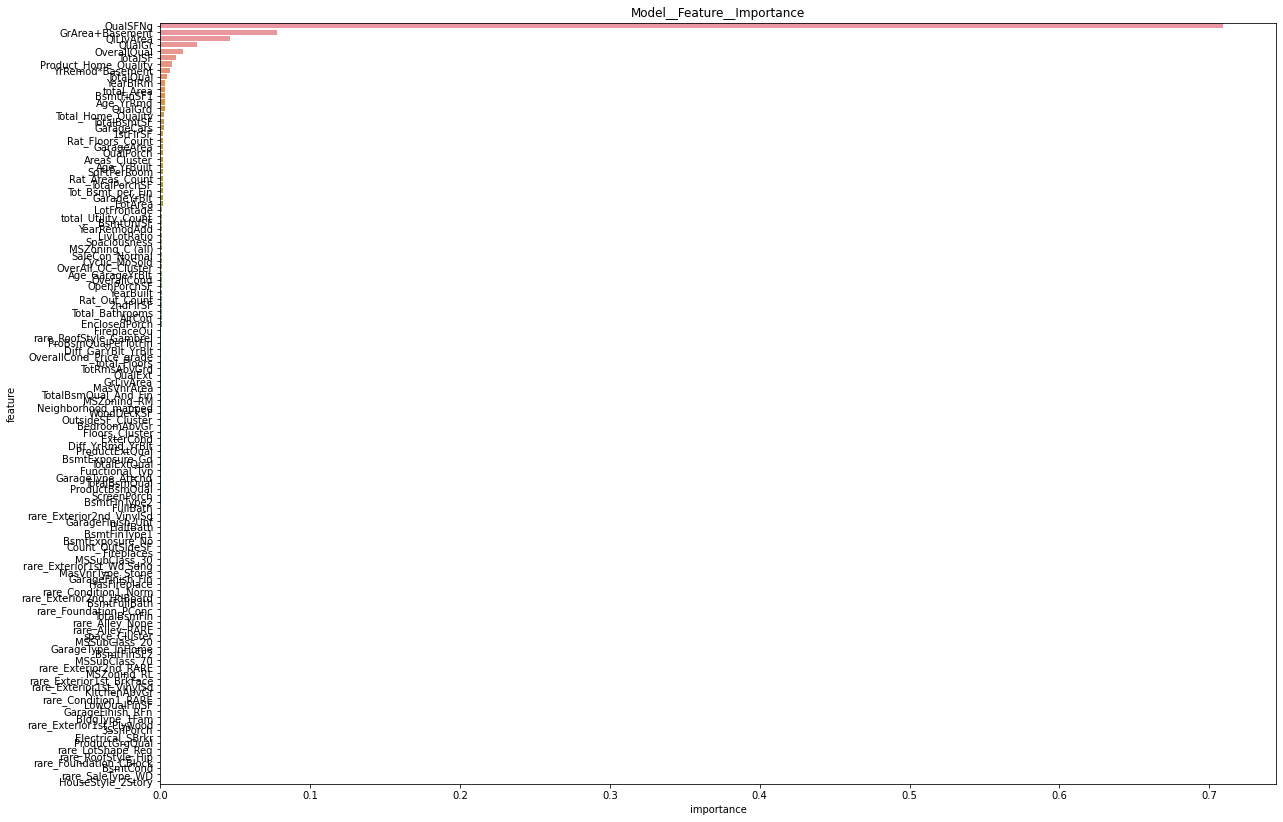

In [291]:
def model_feature_importance(model,X_train_df,n_features):
    """
        returns top k features
        
        params:-
                 model = trained model used for feature selection
                X_train_df = Pandas dataframe to extract columns
                n_features = Number of top features to be selected
    """
    feature_importance_df = pd.DataFrame(model.feature_importances_,columns=['importance'])
    feature_importance_df['feature'] = X_train_df.columns
    new_feat= feature_importance_df.sort_values(by=['importance'],ascending= False).head(n_features)['feature'].to_list()
    plt.figure(figsize=(20,14))
    sns.barplot(x='importance',y='feature',data=feature_importance_df.sort_values(by=['importance'],ascending= False).head(n_features))
    plt.title('Model__Feature__Importance')
    plt.show()
    return new_feat
mfi = model_feature_importance(model=rf,X_train_df=data4[features],n_features=120)

In [292]:
mfi

['QualSFNg',
 'GrArea+Basement',
 'QlLivArea',
 'QualGr',
 'OverallQual',
 'TotalSF',
 'Product_Home_Quality',
 'YrRemod*Basement',
 'TotalQual',
 'YearBlRm',
 'total_Area',
 'BsmtFinSF1',
 'Age_YrRmd',
 'QualGrg',
 'Total_Home_Quality',
 'TotalBsmtSF',
 'GarageCars',
 '1stFlrSF',
 'Rat_Floors_Count',
 'GarageArea',
 'QualPorch',
 'Areas_Cluster',
 'Age_YrBuilt',
 'SqFtPerRoom',
 'Rat_Areas_Count',
 'TotalPorchSF',
 'Tot_Bsmt_per_Fin',
 'GarageYrBlt',
 'LotArea',
 'LotFrontage',
 'total_Utility_Count',
 'BsmtUnfSF',
 'YearRemodAdd',
 'LivLotRatio',
 'Spaciousness',
 'MSZoning_C (all)',
 'SaleCon_Normal',
 'Cyclic_MoSold',
 'OverAll_QC_Cluster',
 'Age_GarageYrBlt',
 'OverallCond',
 'OpenPorchSF',
 'YearBuilt',
 'Rat_Out_Count',
 '2ndFlrSF',
 'Total_Bathrooms',
 'AirCon',
 'EnclosedPorch',
 'FireplaceQu',
 'rare_RoofStyle_Gambrel',
 'ProBsmQualPerTotFin',
 'Diff_GarYBlt_YrBlt',
 'OverallCond_Price_grade',
 'total_Floors',
 'TotRmsAbvGrd',
 'QualExt',
 'GrLivArea',
 'MasVnrArea',
 'TotalB

In [293]:
run_fold(df_train_full=data4,target='SalePrice',model =hgrd,columns=features,alias='hgrd')

fold 1 ..rmse_exp_orig == 27871.139280844975 , rmse_log_log == 0.12971789284956287
fold 2 ..rmse_exp_orig == 32891.78785739464 , rmse_log_log == 0.14558018178067264
fold 3 ..rmse_exp_orig == 26390.13148788078 , rmse_log_log == 0.1272900576494072
fold 4 ..rmse_exp_orig == 26268.577560509322 , rmse_log_log == 0.1215981921637487
fold 5 ..rmse_exp_orig == 27036.00567719622 , rmse_log_log == 0.12154192676674219
hgrd mean_rmse_exp_orig = 28091.528 ± 2466.702
hgrd mean_rmse_log_log = 0.129 ± 0.009


28091.528372765188

In [ ]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

def run_fold(df_train_full,target,columns,model,alias='OutlierPresnt'):
    errors_log_log = []
    errors_exp_orig  = []
    fold=1
    for train_idx, val_idx in kfold.split(df_train_full):
        #print("fold ",fold)
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train_orig = df_train[target].values
        y_val_orig = df_val[target].values
        
#y_train_orig = df_train.SalePrice.values
#y_val_orig = df_val.SalePrice.values
#y_test_orig = df_test.SalePrice.values

        y_train = np.log1p(y_train_orig)
        y_val = np.log1p(y_val_orig)
        #y_test = np.log1p(df_test.SalePrice.values)

        model = train(df_train[columns], y_train,model)
        y_pred = predict(df_val[columns],  model)
        y_pred_exp = np.exp(y_pred)
        
        error_log_log = rmse(y_val,y_pred)
        error_exp_orig = rmse(y_val_orig,y_pred_exp)
        print(f'fold {fold} ..rmse_exp_orig == {error_exp_orig} , rmse_log_log == {error_log_log}')
        errors_exp_orig.append(error_exp_orig)
        errors_log_log.append(error_log_log)
        fold+=1
    print(alias ,'mean_rmse_exp_orig = %0.3f ± %0.3f'% ( np.mean(errors_exp_orig), np.std(errors_exp_orig)))
    print(alias,'mean_rmse_log_log = %0.3f ± %0.3f' % ( np.mean(errors_log_log), np.std(errors_log_log)))
    return np.mean(errors_exp_orig)

In [162]:
hgrd.fit(data4[features],np.log1p(data4.SalePrice))
hgrd_preds = hgrd.predict(data4[features])

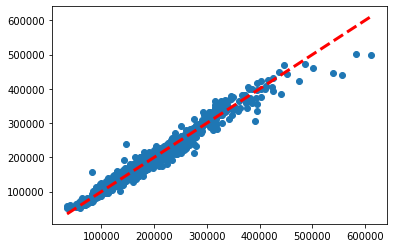

In [169]:
plt.scatter(data4.SalePrice,np.exp(hgrd_preds))
plt.plot([data4.SalePrice.min(), data4.SalePrice.max()], [data4.SalePrice.min(), data4.SalePrice.max()], 'k--', c='red', lw=3)

Extiamtor RandomForestRegressor(min_samples_split=10, n_estimators=200)


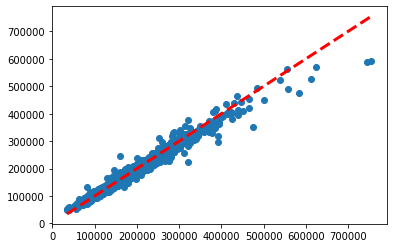

rmse = 14349.19922744441

Extiamtor LGBMRegressor(bagging_fraction=0.35711, bagging_freq=7, bagging_seed=42,
              feature_fraction=0.1294, feature_fraction_seed=42,
              learning_rate=0.00721, max_bin=163, min_data_in_leaf=8,
              n_estimators=3500, num_leaves=5, objective='regression')
[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


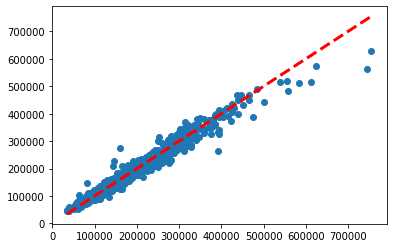

rmse = 15990.491067839697

Extiamtor HistGradientBoostingRegressor(learning_rate=0.15, loss='least_squares',
                              max_depth=2, max_iter=225, max_leaf_nodes=29,
                              min_samples_leaf=40, random_state=42)


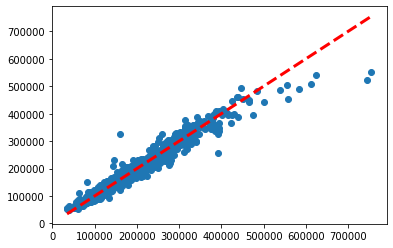

rmse = 18050.698769704824

Extiamtor XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4064, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0139, max_delta_step=0, max_depth=4,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=4500, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
             seed=42, subsample=0.7968, tree_method='exact',
             validate_parameters=1, verbosity=None)


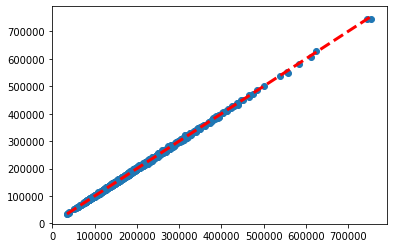

rmse = 2143.7308433403464



In [294]:
estimators = [rf,lightgbm,hgrd,xgboost]
for model in estimators:
    print(f"Extiamtor {model}")
    model.fit(data4[features],np.log1p(data4.SalePrice))
    model_preds = model.predict(data4[features])
    plt.scatter(data4.SalePrice,np.exp(model_preds))
    plt.plot([data4.SalePrice.min(), data4.SalePrice.max()], [data4.SalePrice.min(), data4.SalePrice.max()], 'k--', c='red', lw=3)
    plt.show()
    print(f'rmse = {rmse(data4.SalePrice,np.exp(model_preds))}')
    print("================================")
    print()

In [174]:
sub = pd.read_csv('sample_submission.csv')
print(sub.shape)
sub.head()

(1459, 2)


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [175]:
data_test4.shape

(1459, 207)

In [186]:
def make_submission(preds,alias,path='sample_submission.csv',target_col='SalePrice'):
    sub = pd.read_csv(path)
    sub.loc[:,target_col]=preds
    to = 'submissions/submission_'+alias+'.csv'
    sub.to_csv(to,index=False)

In [182]:
def get_preds(model,train,test):    
    model.fit(train[features],np.log1p(train.SalePrice))
    model.fit(train[features],np.log1p(train.SalePrice))
    model_preds = model.predict(test[features])
    preds = np.exp(model_preds)
    return preds

In [183]:
lgb_preds = get_preds(model=lightgbm,train=data4,test=data_test4)

[LightGBM] [Warning] feature_fraction is set=0.1294, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1294
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.35711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [184]:
lgb_preds

array([125580.27752912, 142533.5958383 , 184328.52791162, ...,
       146970.01457877, 119607.25965969, 195463.74776133])

In [187]:
make_submission(preds=lgb_preds,alias='lgb1',path='sample_submission.csv',target_col='SalePrice')

In [188]:
xgb_preds = get_preds(model=xgboost,train=data4,test=data_test4)

In [189]:
xgb_preds

array([126774.23, 151005.1 , 175957.06, ..., 145276.16, 118711.57,
       195323.98], dtype=float32)

In [190]:
make_submission(preds=xgb_preds,alias='xgb1',path='sample_submission.csv',target_col='SalePrice')

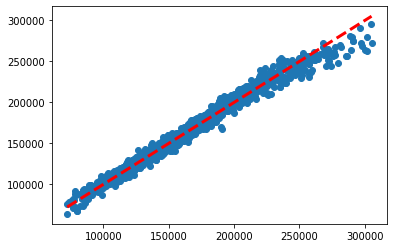

In [191]:
plt.scatter(lgb_preds,xgb_preds)
plt.plot([lgb_preds.min(), lgb_preds.max()], [lgb_preds.min(), lgb_preds.max()], 'k--', c='red', lw=3)


In [192]:
rf_preds = get_preds(model=rf,train=data4,test=data_test4)

In [193]:
make_submission(preds=rf_preds,alias='rf1',path='sample_submission.csv',target_col='SalePrice')

In [194]:
hgrd_preds = get_preds(model=hgrd,train=data4,test=data_test4)

In [195]:
make_submission(preds=hgrd_preds,alias='hgrd1',path='sample_submission.csv',target_col='SalePrice')

In [209]:
conditions = [(test.GrLivArea >4000) , (test['1stFlrSF'] >2500) ,(test.TotalBsmtSF > 3000) ,( test.GarageArea  > 1200) , (test.MasVnrArea>1000)]
ids=[]
for con in conditions:
    print(con.sum())
    ids.extend(test[con].Id.values)
    display(test[con])

1


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1089,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,NaN,NaN,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,NaN,New,Partial,test_col


7


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
19,1480,20,RL,110.0,14300,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003.0,2004.0,Hip,CompShg,VinylSd,VinylSd,BrkFace,1095.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1373.0,Unf,0.0,1473.0,2846.0,GasA,Ex,Y,SBrkr,2696,0,0,2696,1.0,0.0,2,1,3,1,Ex,10,Typ,2,Gd,Attchd,2003.0,Fin,3.0,958.0,TA,TA,Y,220,150,0,0,0,0,NaN,NaN,NaN,0,6,2010.0,WD,Normal,test_col
169,1630,120,RL,28.0,7296,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2004.0,2005.0,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1965.0,Unf,0.0,243.0,2208.0,GasA,Ex,Y,SBrkr,2522,0,0,2522,1.0,0.0,2,0,1,1,Gd,8,Typ,1,Gd,Attchd,2004.0,Fin,2.0,564.0,TA,TA,Y,182,57,0,0,0,0,NaN,NaN,NaN,0,11,2009.0,WD,Normal,test_col
203,1664,20,RL,105.0,13693,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosA,PosA,1Fam,1Story,10,5,2007.0,2007.0,Hip,CompShg,VinylSd,VinylSd,Stone,472.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2288.0,Unf,0.0,342.0,2630.0,GasA,Ex,Y,SBrkr,2674,0,0,2674,2.0,0.0,2,1,2,1,Ex,8,Typ,2,Gd,Attchd,2007.0,Fin,3.0,762.0,TA,TA,Y,360,50,0,0,0,0,NaN,NaN,NaN,0,3,2009.0,WD,Normal,test_col
728,2189,20,RL,123.0,47007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959.0,1996.0,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008.0,WD,Normal,test_col
832,2293,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2007.0,2007.0,Hip,CompShg,VinylSd,VinylSd,Stone,456.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1812.0,Unf,0.0,740.0,2552.0,GasA,Ex,Y,SBrkr,2552,0,0,2552,1.0,0.0,2,0,3,1,Ex,8,Typ,2,Ex,Attchd,2007.0,Fin,3.0,932.0,TA,TA,Y,130,28,0,0,0,0,NaN,NaN,NaN,0,10,2007.0,New,Partial,test_col
1089,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,NaN,NaN,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,NaN,New,Partial,test_col
1113,2574,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8,5,1986.0,1986.0,Gable,CompShg,WdShing,Plywood,None,0.0,Gd,TA,CBlock,Gd,TA,No,Unf,0.0,Unf,0.0,279.0,279.0,GasA,Gd,Y,SBrkr,2726,0,0,2726,0.0,0.0,2,1,2,1,Gd,6,Typ,1,Gd,Attchd,1986.0,Fin,2.0,691.0,Gd,Gd,Y,216,64,169,0,0,228,Ex,NaN,NaN,0,8,2007.0,WD,Normal,test_col


1


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1089,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,NaN,NaN,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,NaN,New,Partial,test_col


4


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,1881,20,RL,90.0,11664,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2002.0,2002.0,Hip,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1234.0,Unf,0.0,335.0,1569.0,GasA,Ex,Y,SBrkr,1611,0,0,1611,1.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2002.0,RFn,3.0,1231.0,TA,TA,Y,262,93,0,0,0,0,NaN,NaN,NaN,0,9,2009.0,WD,Normal,test_col
495,1956,60,RL,NaN,12511,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,1Fam,2Story,7,7,1978.0,1978.0,Mansard,WdShake,Plywood,Plywood,BrkFace,168.0,Gd,TA,PConc,Gd,TA,No,ALQ,988.0,Unf,0.0,432.0,1420.0,GasA,Ex,Y,SBrkr,1420,1420,0,2840,0.0,1.0,2,1,4,1,Gd,8,Min2,2,Gd,Attchd,1978.0,Fin,4.0,1314.0,TA,Gd,Y,0,16,0,0,208,0,NaN,MnPrv,NaN,0,12,2008.0,WD,Normal,test_col
611,2072,50,RL,60.0,10836,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,5,1922.0,1950.0,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,892.0,892.0,GasA,Ex,Y,SBrkr,1254,182,0,1436,0.0,1.0,1,0,3,1,TA,7,Typ,1,Gd,Detchd,1968.0,Unf,4.0,1488.0,Fa,TA,N,0,0,100,0,0,0,NaN,GdWo,NaN,0,6,2008.0,WD,Normal,test_col
701,2162,20,RL,91.0,11778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,9,5,2008.0,2008.0,Hip,CompShg,VinylSd,VinylSd,Stone,554.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,2085.0,Unf,0.0,186.0,2271.0,GasA,Ex,Y,SBrkr,2276,0,0,2276,1.0,0.0,2,0,3,1,Ex,7,Typ,2,Gd,Attchd,2008.0,RFn,3.0,1348.0,Gd,TA,Y,0,0,70,0,255,0,NaN,NaN,NaN,0,6,2008.0,WD,Abnorml,test_col


7


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
19,1480,20,RL,110.0,14300,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003.0,2004.0,Hip,CompShg,VinylSd,VinylSd,BrkFace,1095.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1373.0,Unf,0.0,1473.0,2846.0,GasA,Ex,Y,SBrkr,2696,0,0,2696,1.0,0.0,2,1,3,1,Ex,10,Typ,2,Gd,Attchd,2003.0,Fin,3.0,958.0,TA,TA,Y,220,150,0,0,0,0,NaN,NaN,NaN,0,6,2010.0,WD,Normal,test_col
40,1501,160,FV,NaN,2980,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2000.0,2000.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,1159.0,Gd,TA,PConc,Gd,TA,No,GLQ,466.0,Unf,0.0,290.0,756.0,GasA,Ex,Y,SBrkr,756,756,0,1512,1.0,0.0,2,1,2,1,Gd,5,Typ,0,NaN,Detchd,2000.0,Unf,2.0,440.0,TA,TA,Y,0,32,0,0,0,0,NaN,NaN,NaN,0,5,2010.0,WD,Normal,test_col
516,1977,60,RL,130.0,16900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,1110.0,Gd,TA,PConc,Ex,TA,Mn,GLQ,1075.0,Unf,0.0,404.0,1479.0,GasA,Ex,Y,SBrkr,1515,1134,0,2649,1.0,0.0,2,1,4,1,Gd,10,Typ,1,TA,Attchd,2001.0,Fin,3.0,746.0,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,1,2008.0,WD,Normal,test_col
535,1996,75,RL,84.0,9660,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2.5Unf,8,5,1997.0,1997.0,Hip,CompShg,HdBoard,HdBoard,BrkFace,1290.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1173.0,1173.0,GasA,Ex,Y,SBrkr,1182,1017,0,2199,0.0,0.0,2,1,3,1,Gd,9,Typ,1,TA,Attchd,1997.0,Fin,2.0,516.0,TA,TA,Y,0,131,0,0,0,0,NaN,NaN,NaN,0,9,2008.0,WD,Normal,test_col
579,2040,60,RL,NaN,24572,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,1Fam,2Story,9,3,1977.0,1977.0,Mansard,CompShg,Wd Sdng,Wd Sdng,BrkFace,1050.0,Gd,Gd,CBlock,Gd,TA,No,GLQ,410.0,Unf,0.0,584.0,994.0,GasA,TA,Y,SBrkr,1599,1345,0,2944,0.0,0.0,2,2,3,1,Gd,9,Typ,1,Gd,Attchd,1977.0,RFn,3.0,864.0,TA,TA,Y,140,70,16,0,0,0,NaN,NaN,NaN,0,6,2008.0,WD,Family,test_col
1089,2550,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,NaN,NaN,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,NaN,New,Partial,test_col
1130,2591,20,RL,149.0,19958,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,6,8,1958.0,1995.0,Hip,CompShg,HdBoard,HdBoard,BrkFace,1224.0,TA,Gd,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,585.0,585.0,GasA,Gd,Y,SBrkr,2279,0,0,2279,0.0,0.0,2,1,4,1,Gd,7,Typ,1,Gd,Attchd,1958.0,RFn,2.0,461.0,TA,TA,Y,274,0,0,0,138,0,NaN,GdPrv,NaN,0,7,2007.0,WD,Normal,test_col


In [217]:
set(ids)

{1480,
 1501,
 1630,
 1664,
 1881,
 1956,
 1977,
 1996,
 2040,
 2072,
 2162,
 2189,
 2293,
 2550,
 2574,
 2591}

## atkins

In [218]:
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [221]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

# xgboost:
xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)

# hist gradient boosting regressor:
hgrd= HistGradientBoostingRegressor(    loss= 'least_squares',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225, random_state=42)

In [222]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit(),
    'xgb':xgboost,
    'hgrd':hgrd
}

In [227]:
#features =features.drop(iso_cols)

In [298]:
train_final = data4[features]
log_target = np.log1p(data4['SalePrice'])

In [299]:
test_final = data_test4[features]

In [300]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE
0,-0.095171,-0.131627,0.654978,-0.460599,1.046122,0.878381,1.193962,-0.206020,0.152284,1.165653,0.780329,-0.237394,-0.355480,-0.340020,0.003292,-0.804101,1.181803,-0.133649,0.533750,1.149702,-0.243011,0.793103,1.259695,0.163837,-0.207681,0.949939,-1.012897,-1.007664,1.031414,0.313041,0.352645,0.264059,-0.946016,0.846956,-0.404405,-0.128566,-0.292878,-0.069416,-0.190549,0.415511,1.218819,0.263909,0.306110,0.271263,0.696953,0.256401,-0.488405,-0.196046,-0.300722,0.321917,-0.069433,1.147115,-1.055695,0.965642,-0.483214,0.193712,0.124504,1.648502,0.706504,-0.058275,1.095485,0.773126,0.779697,0.599034,0.326973,0.408691,0.932846,0.26094,0.272066,0.951015,0.791120,0.097411,1.214700,0.350881,0.796987,0.669539,-0.530239,-0.959050,-0.608260,-0.756946,-0.877031,-0.355167,0.259826,-0.288821,0.147815,0.088785,-0.342297,0.091339,-0.106300,1.078263,-0.4813

In [301]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print(name + " trained.")

catboost trained.
br trained.
lightgbm trained.
ridge trained.
omp trained.
xgb trained.
hgrd trained.


In [302]:
features 

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtFinType1',
       ...
       'rare_LotShape_RARE', 'rare_LotShape_Reg', 'rare_LandContour_Lvl',
       'rare_LandContour_RARE', 'rare_LandSlope_Gtl', 'rare_LandSlope_RARE',
       'rare_Foundation_BrkTil', 'rare_Foundation_CBlock',
       'rare_Foundation_PConc', 'rare_Foundation_RARE'],
      dtype='object', length=202)

In [303]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    print(name + " predicted.")
    results[name] = result

catboost predicted.
br predicted.
lightgbm predicted.
ridge predicted.
omp predicted.
xgb predicted.
hgrd predicted.


In [304]:
results

{'catboost': array([1.11934468, 1.0946763 , 1.11560636, 1.13150702, 1.15146159,
        1.10166699, 1.12185099, 1.10008304, 1.15508424, 1.12980308]),
 'br': array([1.11956113, 1.10407035, 1.11464498, 1.12419515, 1.1577466 ,
        1.10740614, 1.12241339, 1.10711276, 1.18613938, 1.13763332]),
 'lightgbm': array([1.13120592, 1.1095756 , 1.11365567, 1.14480794, 1.15519627,
        1.10648314, 1.13739262, 1.10769304, 1.1569194 , 1.1364048 ]),
 'ridge': array([1.12030708, 1.10503056, 1.11534724, 1.12622166, 1.15858494,
        1.10853968, 1.12323512, 1.10607963, 1.18303272, 1.13676245]),
 'omp': array([1.13084905, 1.11472829, 1.12627128, 1.12924562, 1.15872284,
        1.11480334, 1.13148596, 1.1227598 , 1.18543277, 1.14539778]),
 'xgb': array([1.13357885, 1.09595087, 1.1190359 , 1.13448798, 1.14962858,
        1.10294578, 1.12593399, 1.11074744, 1.15298556, 1.128929  ]),
 'hgrd': array([1.1275211 , 1.10634446, 1.11414402, 1.14798494, 1.15558963,
        1.10972151, 1.13284474, 1.11227834,

In [305]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1221084292310237
0.019498787480943844
----------
br
1.1280923218536345
0.02466988783012595
----------
lightgbm
1.1299334389395905
0.01846835029291606
----------
ridge
1.1283141070442444
0.023815487099973078
----------
omp
1.1359696728547939
0.02076655939373277
----------
xgb
1.1254223940522121
0.017711151265774255
----------
hgrd
1.1302205097412439
0.01826240888717277


In [311]:
final_predictions1 = (
    0.5 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['xgb'].predict(test_final)) +
    0.2 * np.exp(models['lightgbm'].predict(test_final)) +
    0.1 * np.exp(models['hgrd'].predict(test_final)) 
    #0.1 * np.exp(models['omp'].predict(test_final))
)

In [312]:
final_predictions1

array([127364.40991231, 158105.40380666, 180529.76662779, ...,
       149708.25431404, 117628.37221818, 206864.31000139])

In [295]:
cat_boost_preds =  np.exp(models['catboost'].predict(test_final))

In [296]:
cat_boost_preds

array([124194.25410453, 143268.23878649, 177437.50470002, ...,
       145862.28811194, 111404.41168534, 192795.8455924 ])

In [297]:
make_submission(preds=cat_boost_preds,alias='cats1',path='sample_submission.csv',target_col='SalePrice')

In [310]:
np.exp(models['omp'].predict(test_final))

array([ 77289.30570237,  95761.56937675, 120517.63440676, ...,
        98603.32083184,  82455.3622084 , 130303.06778219])

In [261]:
round(4.11703100e+263)

411703100000000002186585861853395072662919362600868026420022295492365382094224392680327644878245003624198561940644325930929366974781522607364907444795636033721536055209109084733693426331408435321002935767757086431383402828032461944980924323844698360038085214863360

In [268]:
final_predictions1

array([123025.085973  , 144134.81666065, 178654.35350171, ...,
       148613.87600862, 113737.85840543, 192981.01979162])

In [313]:
make_submission(preds=final_predictions1,alias='atkins2',path='sample_submission.csv',target_col='SalePrice')

In [314]:
#275 frauds
#1301

(1301-275)/(4252-275)

0.2579834045763138

In [315]:
3485/42440 #top 9%

0.08211592836946277

### putting all together

In [319]:
train_predictions1 = (
    0.5 * np.exp(models['catboost'].predict(train_final)) +
    0.2 * np.exp(models['xgb'].predict(train_final)) +
    0.2 * np.exp(models['lightgbm'].predict(train_final)) +
    0.1 * np.exp(models['hgrd'].predict(train_final)) 
    #0.1 * np.exp(models['omp'].predict(test_final))
)

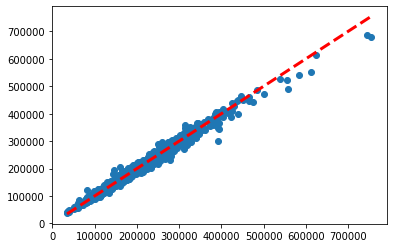

In [320]:
plt.scatter(data4['SalePrice'],train_predictions1)
plt.plot([data4['SalePrice'].min(), data4['SalePrice'].max()], [data4['SalePrice'].min(), data4['SalePrice'].max()], 'k--', c='red', lw=3)


<AxesSubplot:ylabel='Density'>

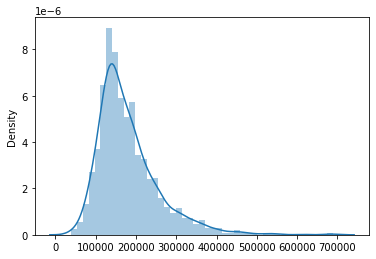

In [323]:
sns.distplot(train_predictions1)

In [321]:
final_predictions1 = (
    0.5 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['xgb'].predict(test_final)) +
    0.2 * np.exp(models['lightgbm'].predict(test_final)) +
    0.1 * np.exp(models['hgrd'].predict(test_final)) 
    #0.1 * np.exp(models['omp'].predict(test_final))
)

In [331]:
final_predictions1[0]

127364.40991230514

In [328]:
## saving

In [327]:
import pickle 

with open('kaggle-ensemble-model.bin', 'wb') as f_out:
    pickle.dump((models['catboost'],models['xgb'],models['lightgbm'],models['hgrd']), f_out)

In [329]:
## opening
loaded={}
with open('kaggle-ensemble-model.bin', 'rb') as f_in:
    loaded['catboost'] ,loaded['xgb'],loaded['lightgbm'],loaded['hgrd'] = pickle.load(f_in)

In [330]:
loaded

{'catboost': <catboost.core.CatBoostRegressor at 0x214a8da8fa0>,
 'xgb': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4064, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0139, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=4500, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              seed=42, subsample=0.7968, tree_method='exact',
              validate_parameters=1, verbosity=None),
 'lightgbm': LGBMRegressor(learning_rate=0.13705339989856127, max_depth=2, n_estimators=273,
               num_leaves=39),
 'hgrd': HistGradientBoostingRegressor(learning_rate=0.15, loss='least_squares',
                               max_depth=2, max_iter=225, max_leaf_nodes=29,
                     

In [332]:
loaded_predictions1 = (
    0.5 * np.exp(loaded['catboost'].predict(test_final)) +
    0.2 * np.exp(loaded['xgb'].predict(test_final)) +
    0.2 * np.exp(loaded['lightgbm'].predict(test_final)) +
    0.1 * np.exp(loaded['hgrd'].predict(test_final)) 
    #0.1 * np.exp(models['omp'].predict(test_final))
)

In [334]:
(final_predictions1 == loaded_predictions1).sum()

1459

In [339]:
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,SalePrice
0,60,RL,4.189655,9.042040,CollgCr,1Fam,2Story,7,1.791759,7.602900,7.602900,BrkFace,5.283204,1.386294,1.386294,No,6,6.561031,0.693147,0.000000,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.693147,0.000000,2,0.693147,3,0.693147,2.197225,0.000000,0,Attchd,7.602900,RFn,2,548,1.386294,Y,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,0,2.197225,4.966335,12,35,3.5,7.790282,4.127134,4006,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.205462,6.059123,7.224753,3288,11.205462,12.814889,0.998529,1.791759,1.791759,0.000000,1.791759,0.0,0.184292,5.369475,7.850493,14.354672,1,4.127134,9.372544,5,7.763446,7.444833,2,6.752270,4.814505,2,0,4,4,3,0.000000,0,-0.499998,208500
1,20,RL,4.394449,9.169623,Veenker,1Fam,1Story,6,2.197225,7.589336,7.589336,None,0.000000,1.386294,1.386294,Gd,5,6.886532,0.693147,0.000000,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.000000,0.693147,2,0.000000,3,0.693147,1.945910,0.693147,3,Attchd,7.589336,RFn,2,460,1.386294,Y,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.079442,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,0,1,1.945910,4.950335,14,48,2.5,7.714677,5.700444,3952,6,2.302585,2.639057,2.079442,2.564949,6,1.94591,2.302585,3.688879,10.804035,7.489412,0.000000,2760,10.804035,12.749928,1.098612,3.465736,3.465736,0.000000,3.465736,0.0,0.123507,5.353437,7.833996,14.729283,1,5.700444,9.440261,4,8.054205,7.141245,1,7.141245,5.353437,3,1,8,7,7,2.197225,1,0.866028,181500
2,60,RL,4.234107,9.328212,CollgCr,1Fam,2Story,7,1.791759,7.601902,7.602401,BrkFace,5.093750,1.386294,1.386294,Mn,6,6.188264,0.693147,0.000000,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,0.693147,0.000000,2,0.693147,3,0.693147,1.945910,0.693147,3,Attchd,7.601902,RFn,2,608,1.386294,Y,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000,1.791759,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.0,0.693147,0.0,1,1,2.197225,5.190732,12,35,3.5,7.728856,3.761200,4003,7,2.564949,2.708050,2.079442,2.564949,7,1.94591,2.302585,3.784190,11.248947,5.686975,7.034388,3648,11.248947,12.858374,0.998529,2.079442,1.945910,0.693147,2.079442,0.0,0.147347,5.699328

<AxesSubplot:ylabel='Density'>

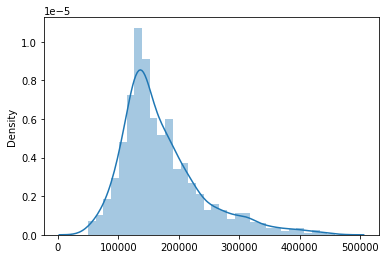

In [322]:
sns.distplot(final_predictions1)

In [398]:
_ ,skew_df= prepare_X_con(df=data,is_train=False)
_ ,skew_df2= prepare_X_con(df=data_test,is_train=False)

Numeric Columns with NA ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']

Created New_Feat : 'ProBsmQualPerTotFin' succesfully!
Created Features list : ['SqFtPe

2    821
3    551
1     88
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'GrArea+Basement', 'YrRemod*Basement', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list 

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,2003,BrkFace,196.0,4,3,4,3,No,6,706,1,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,0,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,0,0,0,None,0,2,2008,5,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,0,8,142.500000,12,35,3.5,2416,61,4006,7,12,14,7,12,7,6,9,43,73530,427,1372.0,3288,73530,367650,1.714286,5,5,0,5.0,0.0,0.202367,213.750000,2566,1714568,1,61.0,11760.0,5,2352.0,1710,2,855.0,122.285714,2,0,4,4,3,0,0
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,1976,None,0.0,3,3,4,3,Gd,5,978,1,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,1,3,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,0,0,0,None,0,5,2007,7,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,0,0,0,1,0,0,1,6,140.222222,14,48,2.5,2240,298,3952,6,9,13,7,12,6,6,9,39,49218,1788,0.0,2760,49218,344526,2.000000,31,31,0,31.0,0.0,0.131458,210.333333,2524,2493712,1,298.0,12584.0,4,3146.0,1262,1,1262.0,210.333333,3,1,8,7,7,8,1


,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.914130,1.914130,True
1,LotArea,12.195142,12.195142,True


skewed columns:


array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'Neighborhood_mapped', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'TotalSF', 'TotalPorchSF', 'ProductExtQual',
       'TotalBsmQual_And_Fin', 'TotalBsmQual', 'ProductBsmQual',
       'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr',
       'Q


skewed features handled

monthsold transformed to a cyclic feature

dropping


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

Numeric Columns with NA ['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'YrSold']
NA handled successfully

Created New_Feat : '['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms']

Created New_Feat : '['TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual',

2    824
3    555
1     80
Name: OverallCond_Price_grade, dtype: int64


Created New_Feat : '['space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']' succesfully!
Created Features list : ['SqFtPerRoom', 'Total_Home_Quality', 'Product_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF', 'YearBlRm', 'TotalExtQual', 'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual', 'TotalBsmFin', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual', 'QualGr', 'QualPorchQualExt', 'QualGrg', 'QlLivArea', 'ProBsmQualPerTotFin', 'Age_YrBuilt', 'Age_YrRmd', 'Diff_YrRmd_YrBlt', 'Age_GarageYrBlt', 'Diff_GarYBlt_YrBlt', 'LivLotRatio', 'Spaciousness', 'GrArea+Basement', 'YrRemod*Basement', 'Count_OutSideSF', 'Rat_Out_Count', 'total_Area', 'Count_Areas', 'Rat_Areas_Count', 'total_Floors', 'Count_Floors', 'Rat_Floors_Count', 'Tot_Bsmt_per_Fin', 'OverallCond_Price_grade', 'space_Cluster', 'Areas_Cluster', 'Floors_Cluster', 'OutsideSF_Cluster', 'OverAll_QC_Cluster']

Created New_Feat : '['YrBlt_Cluster']' succesfully!
Created Features list 

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster
0,20,RH,80.0,11622,NAmes,1Fam,1Story,5,6,1961.0,1961.0,None,0.0,3,3,3,3,No,3,468.0,2,144.0,270.0,882.0,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,0,0,Attchd,1961.0,Unf,1.0,730.0,3,3,Y,140,0,0,0,120,0,None,0,6,2010.0,3,VinylSd,VinylSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,1,0,0,1,0,0,0,7,128.000000,11,30,1.0,1508.0,260,3922.0,6,9,11,6,9,5,6,9,34,30464,1560,0.0,4380.0,30464,91392,1.8,49.0,49.0,0.0,49.0,0.0,0.077095,179.2,1778.0,1729602.0,2,130.0,14130.0,4,3532.5,896,1,896.0,176.4,3,2,6,7,1,0,0
1,20,RL,81.0,14267,NAmes,1Fam,1Story,6,6,1958.0,1958.0,BrkFace,108.0,3,3,3,3,No,5,923.0,1,0.0,406.0,1329.0,3,1329,0,0,1329,0.0,0.0,1,1,3,1,4,6,0,0,Attchd,1958.0,Unf,1.0,312.0,3,3,Y,393,36,0,0,0,0,None,12500,6,2010.0,3,Wd Sdng,Wd Sdng,None,Norm,WD,Hip,IR1,Lvl,Gtl,CBlock,1,1,1,1,1,1,0,1,0,1,0,0,0,8,147.666667,12,36,1.5,2252.0,429,3916.0,6,9,12,6,9,6,6,9,37,49173,2574,648.0,1872.0,49173,147519,1.5,52.0,52.0,0.0,52.0,0.0,0.093152,221.5,2658.0,2602182.0,2,214.5,17345.0,5,3469.0,1329,1,1329.0,221.5,3,4,2,1,4,0,0


,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.578609,0.578609,True
1,LotArea,3.112013,3.112013,True


skewed columns:


array(['LotFrontage', 'LotArea', 'YearBuilt', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageQual', 'GarageCond', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'Neighborhood_mapped', 'AirCon',
       'Electrical_SBrkr', 'Functional_Typ', 'GarageType_InHome',
       'PavedDrive1', 'HasFence', 'MiscFeature1', 'SaleType_New_House',
       'SaleCon_Normal', 'HasPool', 'total_Utility_Count', 'SqFtPerRoom',
       'Total_Home_Quality', 'Total_Bathrooms', 'TotalSF', 'TotalPorchSF',
       'ProductExtQual', 'TotalBsmQual_And_Fin', 'TotalBsmQual',
       'ProductBsmQual', 'TotalGrgQual', 'ProductGrgQual', 'TotalQual',
       'QualGr', 'QualPorch', '


skewed features handled

monthsold transformed to a cyclic feature

dropping


['PoolQC',
 'YrSold',
 'MoSold',
 'ExterQual',
 'BsmtQual',
 'GarageQual',
 'KitchenQual',
 'HeatingQC']

In [383]:
skew_df.iloc[523]

MSSubClass                 60
MSZoning                   RL
LotFrontage             130.0
LotArea                 40094
Neighborhood          Edwards
                       ...   
Floors_Cluster              9
OutsideSF_Cluster           8
OverAll_QC_Cluster          3
YrBlt_Cluster               0
SalePrice                 NaN
Name: 523, Length: 123, dtype: object

In [399]:
skew_df = skew_df.drop(523,axis=0)
skew_df.loc[:,'SalePrice'] = data4.SalePrice
skew_df.loc[:,'Predicted'] = train_predictions1
skew_df.loc[:,'is_train'] = 'Yes'

In [400]:
skew_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,SalePrice,Predicted,is_train
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003,2003,BrkFace,196.0,3,3,No,6,706,1,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,0,Attchd,2003.0,RFn,2,548,3,Y,0,61,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,0,8,142.500000,12,35,3.5,2416,61,4006,7,12,14,7,12,7,6,9,43,73530,427,1372.0,3288,73530,367650,1.714286,5,5,0,5.0,0.0,0.202367,213.750000,2566,1714568,1,61.0,11760.0,5,2352.00,1710,2,855.0,122.285714,2,0,4,4,3,0,0,208500,207963.213951,Yes
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976,1976,None,0.0,3,3,Gd,5,978,1,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,3,Attchd,1976.0,RFn,2,460,3,Y,298,0,0,0,0,0,0,7,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,0,0,0,1,0,0,1,6,140.222222,14,48,2.5,2240,298,3952,6,9,13,7,12,6,6,9,39,49218,1788,0.0,2760,49218,344526,2.000000,31,31,0,31.0,0.0,0.131458,210.333333,2524,2493712,1,298.0,12584.0,4,3146.00,1262,1,1262.0,210.333333,3,1,8,7,7,8,1,181500,184623.116781,Yes
2,60,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2001,2002,BrkFace,162.0,3,3,Mn,6,486,1,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,3,Attchd,2001.0,RFn,2,608,3,Y,0,42,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,178.600000,12,35,3.5,2272,42,4003,7,12,14,7,12,7,6,9,43,76798,294,1134.0,3648,76798,383990,1.714286,7,6,1,7.0,0.0,0.158756,297.666667,2706,1841840,1,42.0,14726.0,5,2945.20,1786,2,893.0,131.428571,2,0,6,4,3,0,0,223500,218771.554455,Yes
3,70,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1915,1970,None,0.0,3,4,No,5,216,1,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,4,Detchd,1998.0,Unf,3,642,3,Y,0,35,272,0,0,0,0,6,Wd Sdng,Wd Shng,None,Norm,WD,Gable,IR1,Lvl,Gtl,BrkTil,0,1,1,1,0,1,0,0,0,0,0,1,1,5,190.777778,12,35,2.0,1933,307,3885,6,9,13,7,12,6,6,9,40,68680,1842,0.0,3852,68680,412080,2.000000,91,36,55,8.0,83.0,0.179791,245.285714,2473,1489320,2,153.5,12665.0,4,3166.25,1717,2,858.5,126.000000,2,0,6,4,2,0,2,140000,153403.282881,Yes
4,60,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000,2000,BrkFace,350.0,3,3,Av,6,655,1,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,Attchd,2000.0,RFn,3,836,3,Y,192,84,0,0,0,0,0,10,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,169.076923,13,40,3.5,2853,276,4000,7,12,14,7,12,7,6,9,44,96712,1932,2450.0,5016,96712,967120,1.714286,8,8,0,8.0,0.0,0.154137,244.222222,3343,2290000,2,138.0,18789.0,5,3757.80,2198,2,1099.0,

In [401]:
#skew_df = skew_df.drop(523,axis=0)
skew_df2.loc[:,'SalePrice'] = final_predictions1
skew_df2.loc[:,'Predicted'] = final_predictions1
skew_df2.loc[:,'is_train'] = 'No'
skew_df2

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,SalePrice,Predicted,is_train
0,20,RH,80.0,11622,NAmes,1Fam,1Story,5,6,1961.0,1961.0,None,0.0,3,3,No,3,468.0,2,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,0,Attchd,1961.0,Unf,1.0,730.0,3,Y,140,0,0,0,120,0,0,3,VinylSd,VinylSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,1,0,0,1,0,0,0,7,128.000000,11,30,1.0,1508.0,260,3922.0,6,9,11,6,9,5,6,9,34,30464,1560,0.0,4380.0,30464,91392,1.800000,49.0,49.0,0.0,49.0,0.0,0.077095,179.200000,1778.0,1729602.0,2,130.0,14130.0,4,3532.500000,896,1,896.0,176.400000,3,2,6,7,1,0,0,127364.409912,127364.409912,No
1,20,RL,81.0,14267,NAmes,1Fam,1Story,6,6,1958.0,1958.0,BrkFace,108.0,3,3,No,5,923.0,1,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,0,Attchd,1958.0,Unf,1.0,312.0,3,Y,393,36,0,0,0,0,12500,3,Wd Sdng,Wd Sdng,None,Norm,WD,Hip,IR1,Lvl,Gtl,CBlock,1,1,1,1,1,1,0,1,0,1,0,0,0,8,147.666667,12,36,1.5,2252.0,429,3916.0,6,9,12,6,9,6,6,9,37,49173,2574,648.0,1872.0,49173,147519,1.500000,52.0,52.0,0.0,52.0,0.0,0.093152,221.500000,2658.0,2602182.0,2,214.5,17345.0,5,3469.000000,1329,1,1329.0,221.500000,3,4,2,1,4,0,0,158105.403807,158105.403807,No
2,60,RL,74.0,13830,Gilbert,1Fam,2Story,5,5,1997.0,1998.0,None,0.0,3,3,No,6,791.0,1,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,3,Attchd,1997.0,Fin,2.0,482.0,3,Y,212,34,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,0,1,1,1,1,1,1,0,0,1,0,1,1,8,162.900000,10,25,2.5,2420.0,246,3995.0,6,9,14,7,12,7,6,9,38,61902,1476,0.0,2892.0,61902,309510,1.714286,13.0,12.0,1.0,13.0,0.0,0.117787,271.500000,2557.0,1854144.0,2,123.0,16869.0,4,4217.250000,1629,2,814.5,132.571429,2,7,9,3,0,9,1,180529.766628,180529.766628,No
3,60,RL,78.0,9978,Gilbert,1Fam,2Story,6,6,1998.0,1998.0,BrkFace,20.0,3,3,No,6,602.0,1,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,4,Attchd,1998.0,Fin,2.0,470.0,3,Y,360,36,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,145.818182,12,36,2.5,2206.0,396,3996.0,6,9,13,6,9,7,6,9,40,64160,2376,120.0,2820.0,64160,320800,1.285714,12.0,12.0,0.0,12.0,0.0,0.160754,229.142857,2530.0,1850148.0,2,198.0,12998.0,5,2599.600000,1604,2,802.0,132.285714,3,7,9,3,4,0,1,185031.643276,185031.643276,No
4,120,RL,43.0,5005,StoneBr,TwnhsE,1Story,8,5,1992.0,1992.0,None,0.0,3,3,No,5,263.0,1,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,0,Attchd,1992.0,RFn,2.0,506.0,3,Y,0,82,0,0,144,0,0,9,HdBoard,HdBoard,None,Norm,WD,Gable,IR1,RARE,Gtl,PConc,0,1,1,1,1,1,

In [390]:
skew_df.shape[0] +skew_df2.shape[0]

2919

In [404]:
(skew_df.columns == skew_df2.columns).sum()

125

In [405]:
for_dashboard = pd.concat([skew_df,skew_df2],axis=0)
for_dashboard.shape

(2918, 125)

In [407]:
for_dashboard

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,rare_Exterior1st,rare_Exterior2nd,rare_Alley,rare_Condition1,rare_SaleType,rare_RoofStyle,rare_LotShape,rare_LandContour,rare_LandSlope,rare_Foundation,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,SalePrice,Predicted,is_train
0,60,RL,65.0,8450,CollgCr,1Fam,2Story,7,5,2003.0,2003.0,BrkFace,196.0,3,3,No,6,706.0,1,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,0,Attchd,2003.0,RFn,2.0,548.0,3,Y,0,61,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,Reg,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,0,8,142.500000,12,35,3.5,2416.0,61,4006.0,7,12,14,7,12,7,6,9,43,73530,427,1372.0,3288.0,73530,367650,1.714286,5.0,5.0,0.0,5.0,0.0,0.202367,213.750000,2566.0,1714568.0,1,61.0,11760.0,5,2352.000000,1710,2,855.0,122.285714,2,0,4,4,3,0,0,208500.000000,207963.213951,Yes
1,20,RL,80.0,9600,Veenker,1Fam,1Story,6,8,1976.0,1976.0,None,0.0,3,3,Gd,5,978.0,1,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,3,Attchd,1976.0,RFn,2.0,460.0,3,Y,298,0,0,0,0,0,0,7,MetalSd,MetalSd,None,RARE,WD,Gable,Reg,Lvl,Gtl,CBlock,0,1,1,1,1,1,0,0,0,1,0,0,1,6,140.222222,14,48,2.5,2240.0,298,3952.0,6,9,13,7,12,6,6,9,39,49218,1788,0.0,2760.0,49218,344526,2.000000,31.0,31.0,0.0,31.0,0.0,0.131458,210.333333,2524.0,2493712.0,1,298.0,12584.0,4,3146.000000,1262,1,1262.0,210.333333,3,1,8,7,7,8,1,181500.000000,184623.116781,Yes
2,60,RL,68.0,11250,CollgCr,1Fam,2Story,7,5,2001.0,2002.0,BrkFace,162.0,3,3,Mn,6,486.0,1,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,3,Attchd,2001.0,RFn,2.0,608.0,3,Y,0,42,0,0,0,0,0,5,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1,1,0,0,0,1,0,1,1,8,178.600000,12,35,3.5,2272.0,42,4003.0,7,12,14,7,12,7,6,9,43,76798,294,1134.0,3648.0,76798,383990,1.714286,7.0,6.0,1.0,7.0,0.0,0.158756,297.666667,2706.0,1841840.0,1,42.0,14726.0,5,2945.200000,1786,2,893.0,131.428571,2,0,6,4,3,0,0,223500.000000,218771.554455,Yes
3,70,RL,60.0,9550,Crawfor,1Fam,2Story,7,5,1915.0,1970.0,None,0.0,3,4,No,5,216.0,1,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,4,Detchd,1998.0,Unf,3.0,642.0,3,Y,0,35,272,0,0,0,0,6,Wd Sdng,Wd Shng,None,Norm,WD,Gable,IR1,Lvl,Gtl,BrkTil,0,1,1,1,0,1,0,0,0,0,0,1,1,5,190.777778,12,35,2.0,1933.0,307,3885.0,6,9,13,7,12,6,6,9,40,68680,1842,0.0,3852.0,68680,412080,2.000000,91.0,36.0,55.0,8.0,83.0,0.179791,245.285714,2473.0,1489320.0,2,153.5,12665.0,4,3166.250000,1717,2,858.5,126.000000,2,0,6,4,2,0,2,140000.000000,153403.282881,Yes
4,60,RL,84.0,14260,NoRidge,1Fam,2Story,8,5,2000.0,2000.0,BrkFace,350.0,3,3,Av,6,655.0,1,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,3,Attchd,2000.0,RFn,3.0,836.0,3,Y,192,84,0,0,0,0,0,10,VinylSd,VinylSd,None,Norm,WD,Gable,IR1,Lvl,Gtl,PConc,1,1,1,1,1

In [406]:
for_dashboard.isna().sum()[for_dashboard.isna().sum()>0]

Series([], dtype: int64)

In [408]:
for_dashboard.to_csv("for_dashboard.csv",index=False)

In [393]:
data4.to_csv("ALL_train.csv",index=False)

In [409]:
data4

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,-0.095171,-0.131627,0.654978,-0.460599,1.046122,0.878381,1.193962,-0.206020,0.152284,1.165653,0.780329,-0.237394,-0.355480,-0.340020,0.003292,-0.804101,1.181803,-0.133649,0.533750,1.149702,-0.243011,0.793103,1.259695,0.163837,-0.207681,0.949939,-1.012897,-1.007664,1.031414,0.313041,0.352645,0.264059,-0.946016,0.846956,-0.404405,-0.128566,-0.292878,-0.069416,-0.190549,0.415511,1.218819,0.263909,0.306110,0.271263,0.696953,0.256401,-0.488405,-0.196046,-0.300722,0.321917,-0.069433,1.147115,-1.055695,0.965642,-0.483214,0.193712,0.124504,1.648502,0.706504,-0.058275,1.095485,0.773126,0.779697,0.599034,0.326973,0.408691,0.932846,0.26094,0.272066,0.951015,0.791120,0.097411,1.214700,0.350881,0.796987,0.669539,-0.530239,-0.959050,-0.608260,-0.756946,-0.877031,-0.355167,0.259826,-0.288821,0.147815,0.088785,-0.342297,0.091339,-0.106300,1.0782

In [410]:
data_test4

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Neighborhood_mapped,MasExist,AirCon,Electrical_SBrkr,Functional_Typ,GarageType_InHome,PavedDrive1,HasFence,MiscFeature1,SaleType_New_House,SaleCon_Normal,HasPool,Has2ndFloor,HasFireplace,total_Utility_Count,SqFtPerRoom,Total_Home_Quality,Product_Home_Quality,Total_Bathrooms,TotalSF,TotalPorchSF,YearBlRm,TotalExtQual,ProductExtQual,TotalBsmQual_And_Fin,TotalBsmQual,ProductBsmQual,TotalBsmFin,TotalGrgQual,ProductGrgQual,TotalQual,QualGr,QualPorch,QualExt,QualGrg,QlLivArea,QualSFNg,ProBsmQualPerTotFin,Age_YrBuilt,Age_YrRmd,Diff_YrRmd_YrBlt,Age_GarageYrBlt,Diff_GarYBlt_YrBlt,LivLotRatio,Spaciousness,GrArea+Basement,YrRemod*Basement,Count_OutSideSF,Rat_Out_Count,total_Area,Count_Areas,Rat_Areas_Count,total_Floors,Count_Floors,Rat_Floors_Count,Tot_Bsmt_per_Fin,OverallCond_Price_grade,space_Cluster,Areas_Cluster,Floors_Cluster,OutsideSF_Cluster,OverAll_QC_Cluster,YrBlt_Cluster,Cyclic_MoSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,rare_Exterior1st_BrkFace,rare_Exterior1st_CemntBd,rare_Exterior1st_HdBoard,rare_Exterior1st_MetalSd,rare_Exterior1st_Plywood,rare_Exterior1st_RARE,rare_Exterior1st_VinylSd,rare_Exterior1st_Wd Sdng,rare_Exterior1st_WdShing,rare_Exterior2nd_CmentBd,rare_Exterior2nd_HdBoard,rare_Exterior2nd_MetalSd,rare_Exterior2nd_Plywood,rare_Exterior2nd_RARE,rare_Exterior2nd_VinylSd,rare_Exterior2nd_Wd Sdng,rare_Exterior2nd_Wd Shng,rare_Alley_None,rare_Alley_RARE,rare_Condition1_Norm,rare_Condition1_RARE,rare_SaleType_COD,rare_SaleType_ConLD,rare_SaleType_New,rare_SaleType_RARE,rare_SaleType_WD,rare_RoofStyle_Flat,rare_RoofStyle_Gable,rare_RoofStyle_Gambrel,rare_RoofStyle_Hip,rare_RoofStyle_RARE,rare_LotShape_IR1,rare_LotShape_RARE,rare_LotShape_Reg,rare_LandContour_Lvl,rare_LandContour_RARE,rare_LandSlope_Gtl,rare_LandSlope_RARE,rare_Foundation_BrkTil,rare_Foundation_CBlock,rare_Foundation_PConc,rare_Foundation_RARE,SalePrice
0,0.508353,0.486131,-0.795118,24.530725,-0.330864,187473.961634,-0.814114,-0.20602,0.152284,-0.258311,0.643093,1.189924,2.341989,-0.024536,0.029390,-0.659856,-0.869439,-0.133649,-1.412168,-0.832529,-0.243011,-1.026295,-0.768931,-1.061998,-0.207681,-0.945997,-1.012897,-1.007664,156778.316021,-1.026334,1.204969,0.264059,0.960774,-1.072458,-0.404405,-0.128566,3.124990,-0.069416,-0.190549,-0.498156,-0.820466,0.263909,0.30611,0.271263,0.696953,0.256401,2.047479,-0.196046,-0.300722,0.321917,-0.069433,-0.871752,-1.055695,0.425225,-1.105142,-5.432238,-0.418388,-1.935752,-0.591974,0.634590,-0.748367,-0.709122,-0.664964,0.099481,-0.071997,-0.188051,0.088015,0.260940,0.272066,-0.429808,-1.263349,0.566654,-0.821408,1.181213,-1.249868,-0.883091,-0.460551,0.654307,36.054028,-0.756946,36.408991,-0.355167,-1.032308,-1.213443,-1.028894,0.092564,0.9

In [394]:
data_test4.to_csv("ALL_test.csv",index=False)